# Network Analysis with BigQuery
## Bachelor Thesis Data Analysis

This notebook contains templates and utilities for analyzing social network data stored in BigQuery.

In [646]:
# Enable inline plotting
%matplotlib inline

In [647]:
import os

os.environ[
    'GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/zetta/projects/twitter-analysis-python/.secrets/service-account.json'

creds_path = os.environ.get("GOOGLE_APPLICATION_CREDENTIALS")
print(f"Current credentials path: {creds_path}")

# Define global output directory
OUTPUT_DIR = "outputs"  # Modify this if needed

# Ensure the directory exists
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Figure size
PLOT_FIGURE_SIZE = (12, 12 / 16 * 9)
PLOT_DPI = 300

# Font sizes
# TITLE_FONT_SIZE = 20
# DEFAULT_FONT_SIZE = 15
# AXIS_FONT_SIZE = 15
# LEGEND_FONT_SIZE = 15

BASE_FONT_SIZE = 14
TITLE_FONT_SIZE = BASE_FONT_SIZE + 2
DEFAULT_FONT_SIZE = BASE_FONT_SIZE
AXIS_FONT_SIZE = BASE_FONT_SIZE
LEGEND_FONT_SIZE = BASE_FONT_SIZE

XTICK_LABEL_SIZE = BASE_FONT_SIZE
YTICK_LABEL_SIZE = BASE_FONT_SIZE

# Font weights
FONT_TITLE_WEIGHT = 'regular'
FONT_WEIGHT = 'regular'
FONT_FAMILY = 'sans-serif'
FONT_NAMES = ['Arial']

# Padding
TITLE_PAD = 15

ELECTION_DATE = datetime(2021, 9, 26)
ELECTION_DATE_LABEL = 'Election Day (Sep 26, 2021)'

# Line width
LINE_WIDTH = 3
MARKER_SIZE = 10

# Legend
LEGEND_POSITION = 'upper left'
LEGEND_FRAME_ALPHA = 0.9
LEGEND_FONT_SIZE = 12
LEGEND_EDGE_COLOR = 'lightgray'

# Grid
GRID_COLOR = '#E0E0E0'
GRID_ALPHA = 0.5

COLOR_PARTY = {
    "cdu": "#32302e",
    "spdde": "#e3000f",
    "csu": "#00568d",
    "fdp": "#ffed00",
    "die_gruenen": "#46962b",
    "afd": "#009ee0",
    "dielinke": "#562883"
}

# Map party IDs to proper names
PARTY_NAMES = {
    "cdu": "CDU",
    "spdde": "SPD",
    "csu": "CSU",
    "fdp": "FDP",
    "die_gruenen": "Die Grünen",
    "dielinke": "Die Linke",
    "afd": "AfD"
}

QUERY_USE_CACHE = True

Current credentials path: /Users/zetta/projects/twitter-analysis-python/.secrets/service-account.json


## 1. Setup and Configuration

Import libraries and set up BigQuery connections.

In [648]:
# Data handling and analysis
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# BigQuery
from google.cloud import bigquery
from google.cloud.exceptions import GoogleCloudError

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap

# Define colors
colors = ['#4A4A4A',  # Dark Gray - Good for "Overall" or neutral data
          '#4C72B0',  # Muted Blue - Calm, reliable
          '#C44E52',  # Muted Red - Strong, noticeable
          '#55A868',  # Muted Green - Natural, balanced
          '#8172B2',  # Muted Purple - Soft but distinct
          '#CCB974']  # Muted Yellow - Warm, highlight-friendly
sns.set_palette(sns.color_palette(colors))

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = PLOT_FIGURE_SIZE
plt.rcParams['font.family'] = FONT_FAMILY

# plt.rcParams['axes.labelsize'] = AXIS_FONT_SIZE
# plt.rcParams['axes.titlesize'] = AXIS_FONT_SIZE
plt.rcParams['axes.labelcolor'] = "#6A6A6A"
plt.rcParams['axes.labelweight'] = "light"
plt.rcParams['font.size'] = BASE_FONT_SIZE

# plt.rcParams['axes.titleweight'] = "light"
# plt.rcParams['axes.titlecolor'] = "#6A6A6A"
plt.rcParams['figure.titleweight'] = "medium"
plt.rcParams['xtick.labelsize'] = XTICK_LABEL_SIZE
plt.rcParams['ytick.labelsize'] = YTICK_LABEL_SIZE


plt.rcParams['axes.titlepad'] = 10
plt.rcParams['axes.labelpad'] = 10

# Grid
plt.rcParams['grid.alpha'] = 0.5  # Adjust grid transparency (lighter for clarity)
plt.rcParams['grid.linestyle'] = '--'  # Use dashed lines for a cleaner look
plt.rcParams['grid.color'] = "#D3D3D3"  # Light gray for subtle gridlines

# Legend
# plt.rcParams['legend.frameon'] = True  # Keep a frame around legends
plt.rcParams['legend.framealpha'] = LEGEND_FRAME_ALPHA  # Make the frame slightly transparent
plt.rcParams['legend.edgecolor'] = LEGEND_EDGE_COLOR  # Match with axes edge color
plt.rcParams['legend.fontsize'] = LEGEND_FONT_SIZE  # Set a reasonable default legend font size


In [649]:
# BigQuery configuration
project_id = "grounded-nebula-408412"
dataset = "twitter_analysis_30_network_analysis"

# Initialize BigQuery client
client = bigquery.Client(project=project_id)

In [650]:
# Utility functions for plot formatting
def format_plot(ax,
                title=None,
                xlabel=None,
                ylabel=None,
                ylim_start=0,
                ylim_end=None,
                legend_loc=None,
                grid=True):
    """Apply standard formatting to a matplotlib axis."""
    if title:
        ax.set_title(title, fontweight=FONT_TITLE_WEIGHT, pad=TITLE_PAD, fontsize=TITLE_FONT_SIZE)

    if xlabel:
        ax.set_xlabel(xlabel, fontsize=AXIS_FONT_SIZE)

    if ylabel:
        ax.set_ylabel(ylabel, fontsize=AXIS_FONT_SIZE)

    # Set y-axis limits
    if ylim_end is not None:
        ax.set_ylim(ylim_start, ylim_end)
    elif ylim_start > 0:
        # Only set bottom limit
        ax.set_ylim(bottom=ylim_start)

    # Grid
    if grid:
        ax.grid(True, linestyle="--", alpha=GRID_ALPHA, color=GRID_COLOR)
        ax.set_axisbelow(True)  # Put grid behind data points

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Legend if requested
    if legend_loc:
        ax.legend(loc=legend_loc,
                  frameon=True,
                  framealpha=LEGEND_FRAME_ALPHA,
                  edgecolor=LEGEND_EDGE_COLOR,
                  fontsize=LEGEND_FONT_SIZE)

    return ax

def add_election_line(ax, label=True):
    """Add a vertical line for the election date."""
    line = ax.axvline(
        ELECTION_DATE,
        color='red',
        linestyle='--',
        linewidth=LINE_WIDTH,
        label=ELECTION_DATE_LABEL if label else None
    )
    return line

## 2. BigQuery Utilities

This section includes utility functions for working with BigQuery:
- List all tables in the dataset
- Retrieve the schema of a specific table

In [651]:
def list_tables():
    """List all tables in the dataset."""
    try:
        dataset_ref = client.dataset(dataset)
        tables = list(client.list_tables(dataset_ref))
        table_names = [table.table_id for table in tables]
        print("Tables in dataset:")
        for table in table_names:
            print(f"- {table}")
    except GoogleCloudError as e:
        print(f"Error listing tables: {str(e)}")

In [652]:
def get_table_schema(table_id, dataset=dataset):
    """Retrieve the schema of a given BigQuery table."""
    try:
        table_ref = client.dataset(dataset).table(table_id)
        table = client.get_table(table_ref)
        schema_df = pd.DataFrame([
            {"Column Name": field.name, "Data Type": field.field_type, "Mode": field.mode}
            for field in table.schema
        ])
        return schema_df
    except GoogleCloudError as e:
        print(f"Error fetching schema: {str(e)}")
        return pd.DataFrame()

## 3. Query Execution Function

In [653]:
def run_query(query, use_cache=True):
    """Execute a BigQuery query and return results as a DataFrame."""
    try:
        # Configure the query job to use cache if requested
        job_config = bigquery.QueryJobConfig(use_query_cache=use_cache)

        # Execute the query
        query_job = client.query(query, job_config=job_config)

        # Convert to DataFrame without using the BigQuery Storage API
        results_df = query_job.to_dataframe(create_bqstorage_client=False)

        # Print information about the results
        print(f"Query executed successfully. Retrieved {len(results_df)} rows.")
        if len(results_df) > 0:
            print(f"Columns: {list(results_df.columns)}")
        else:
            print("Warning: Query returned no results.")

        return results_df

    except Exception as e:
        print(f"Error executing query: {str(e)}")
        # Return an empty DataFrame so code can continue without errors
        return pd.DataFrame()

## 4. Network Size Visualization

### Query - toxicity metrics for specific German political party accounts for 2021 only

Query executed successfully. Retrieved 84 rows.
Columns: ['month_start_str', 'node_id', 'toxicity_sent_avg', 'toxicity_received_avg']
Query executed successfully. Retrieved 84 rows.
Columns: ['month_start_str', 'node_id', 'toxicity_sent_avg', 'toxicity_received_avg']
file_name average_toxicity_sent_by_official_german_political_party_accounts_on_twitter_(2021).png


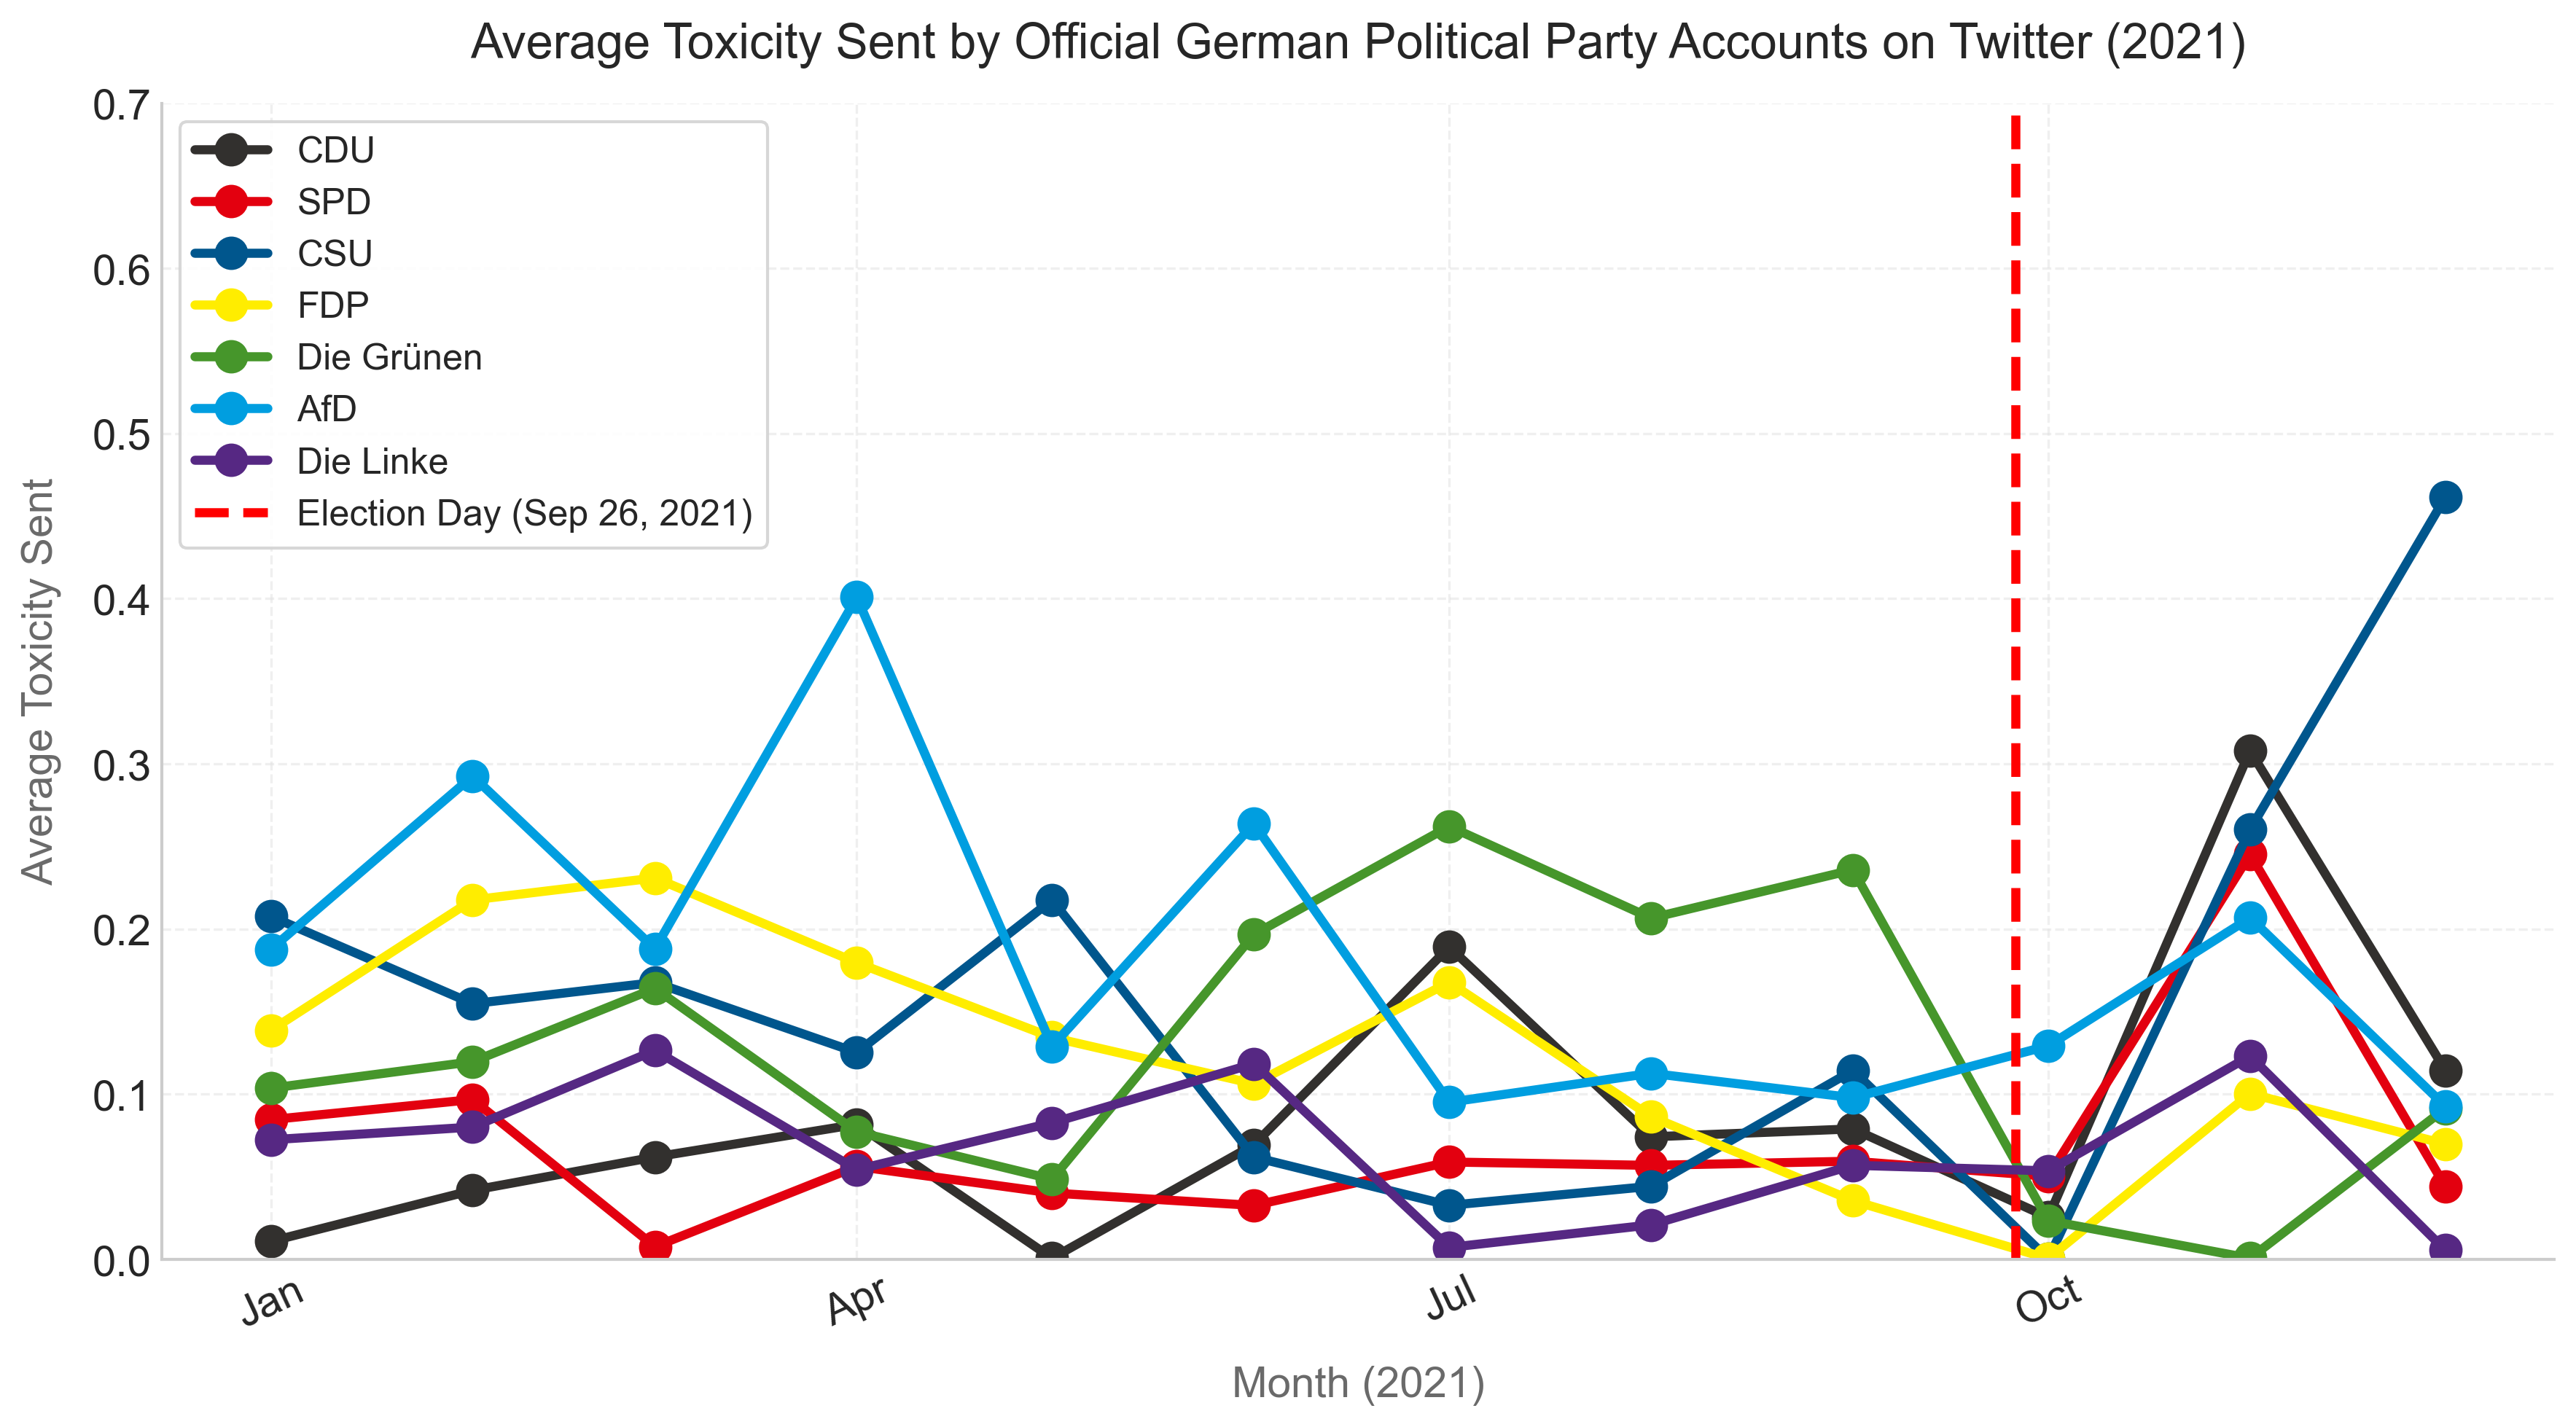

file_name average_toxicity_received_by_official_german_political_party_accounts_on_twitter_(2021).png


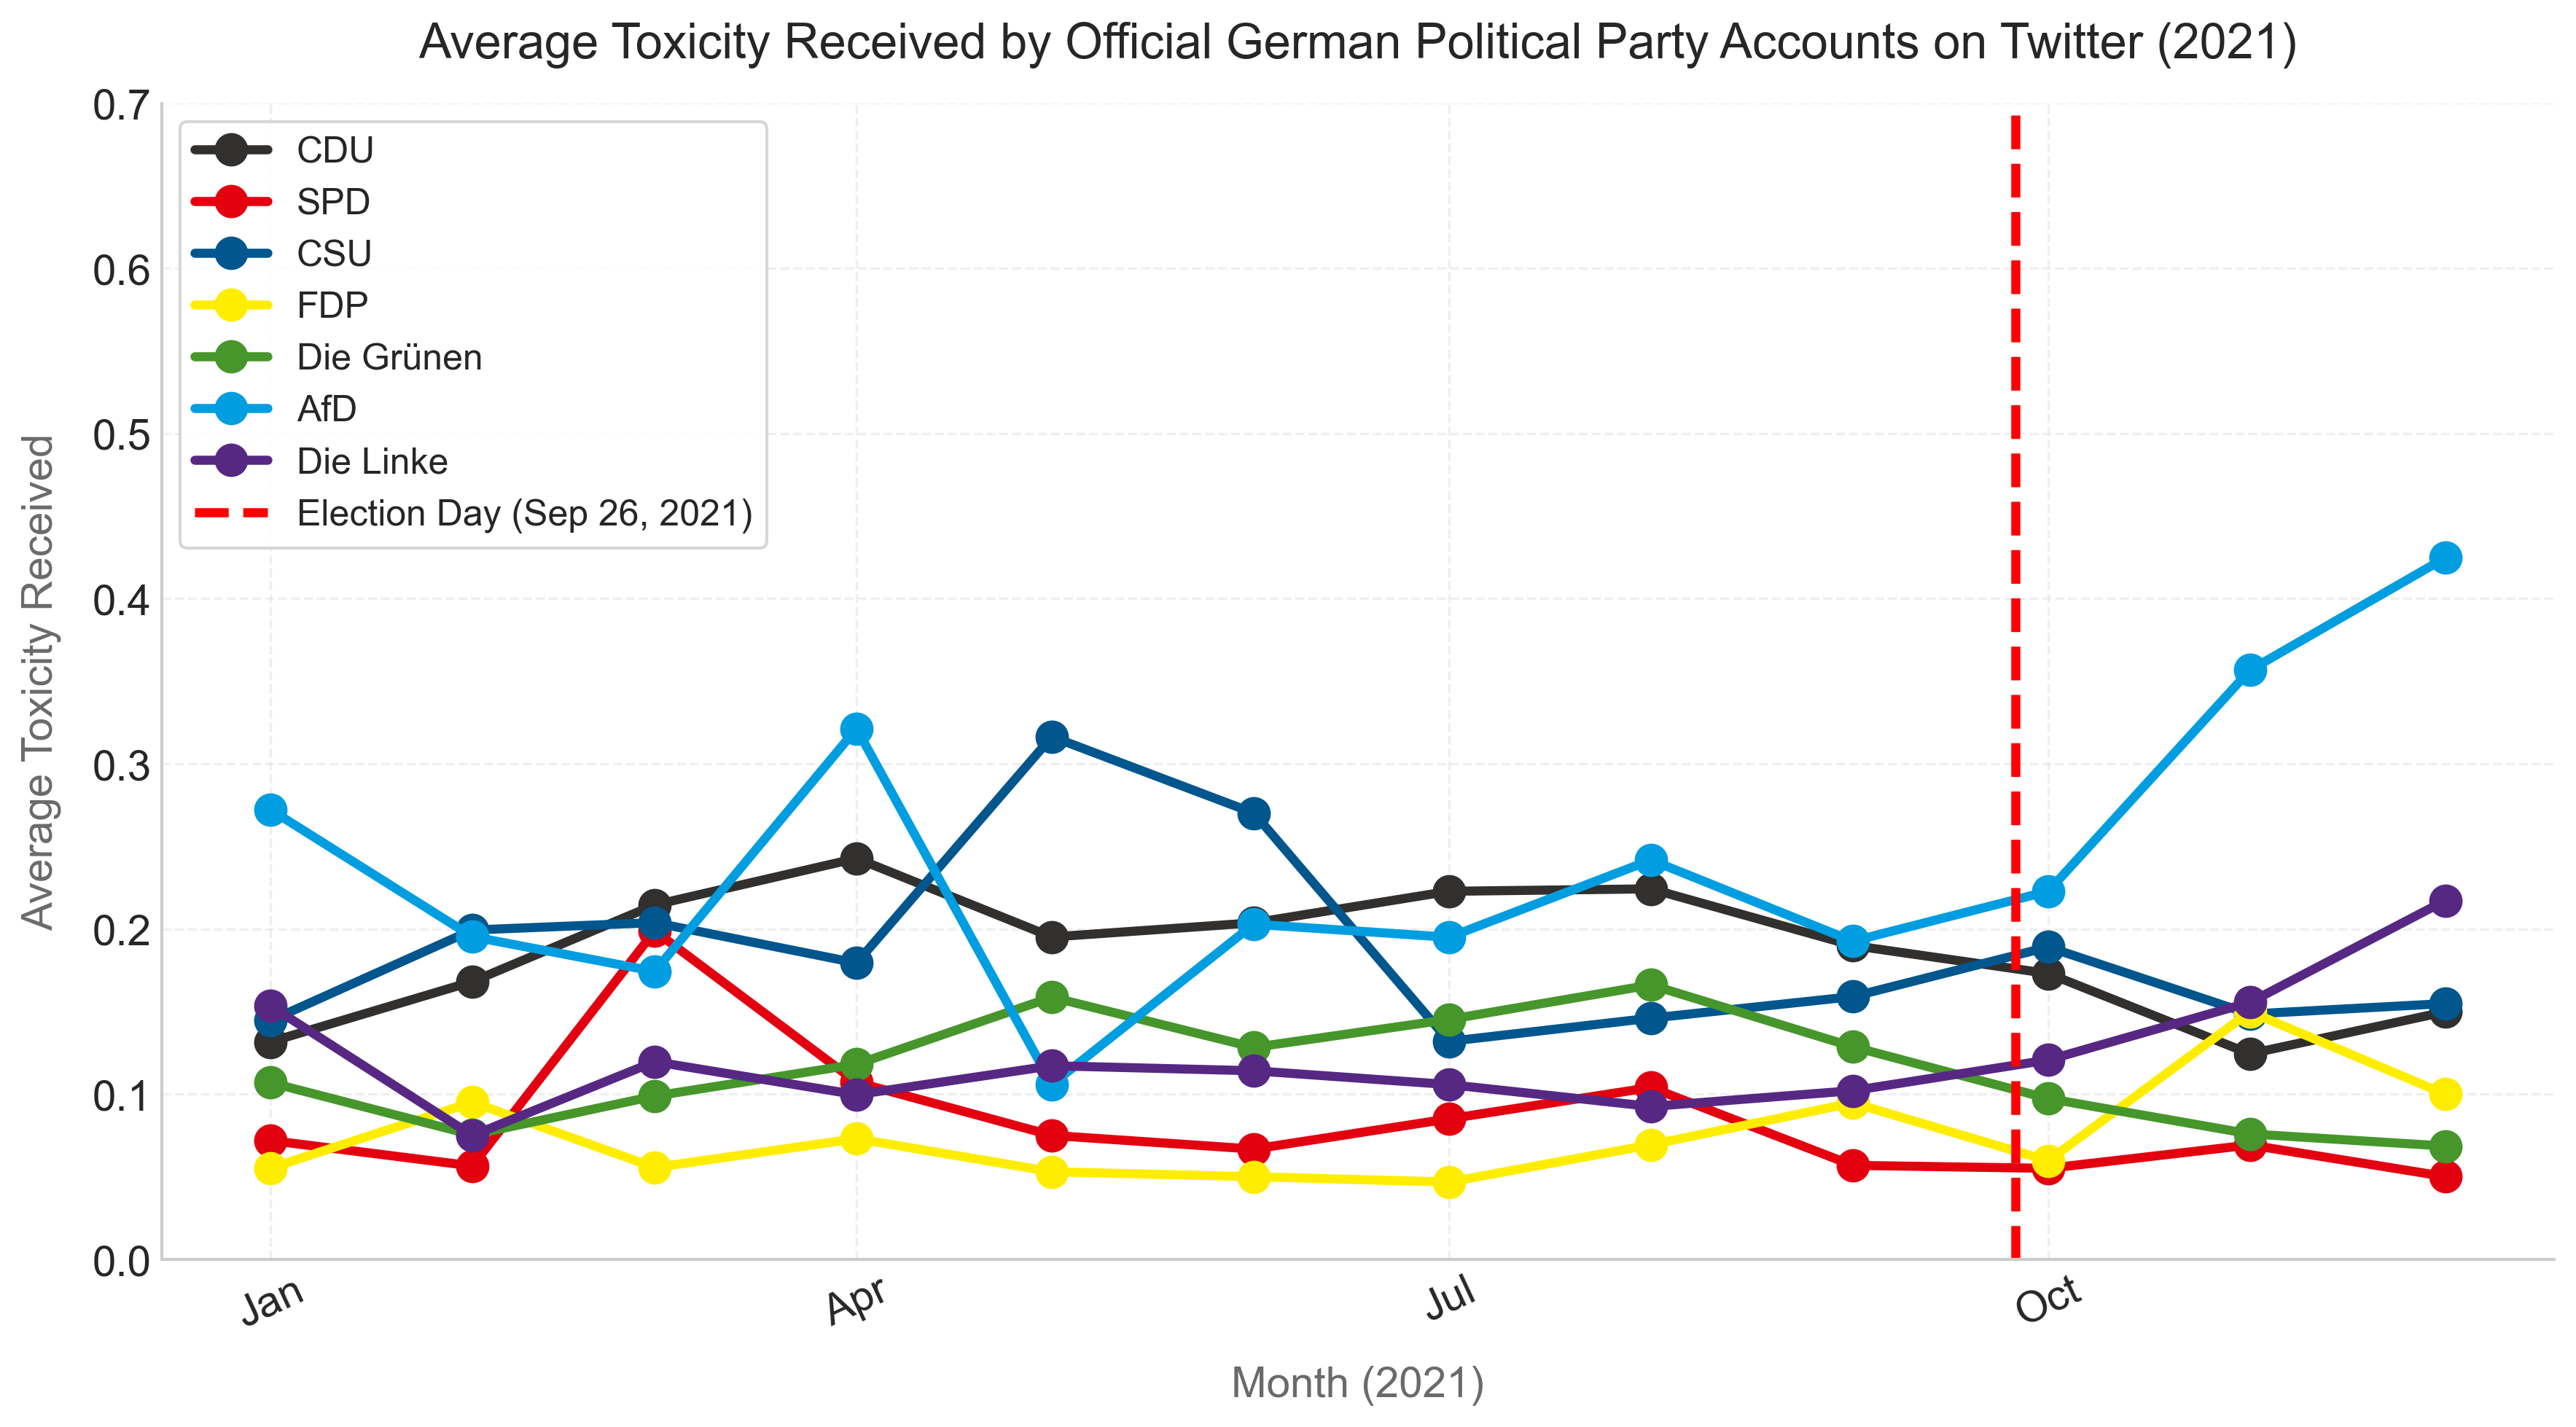

file_name aggregated_average_toxicity_sent_by_party-affiliated_accounts_on_twitter_(2021).png


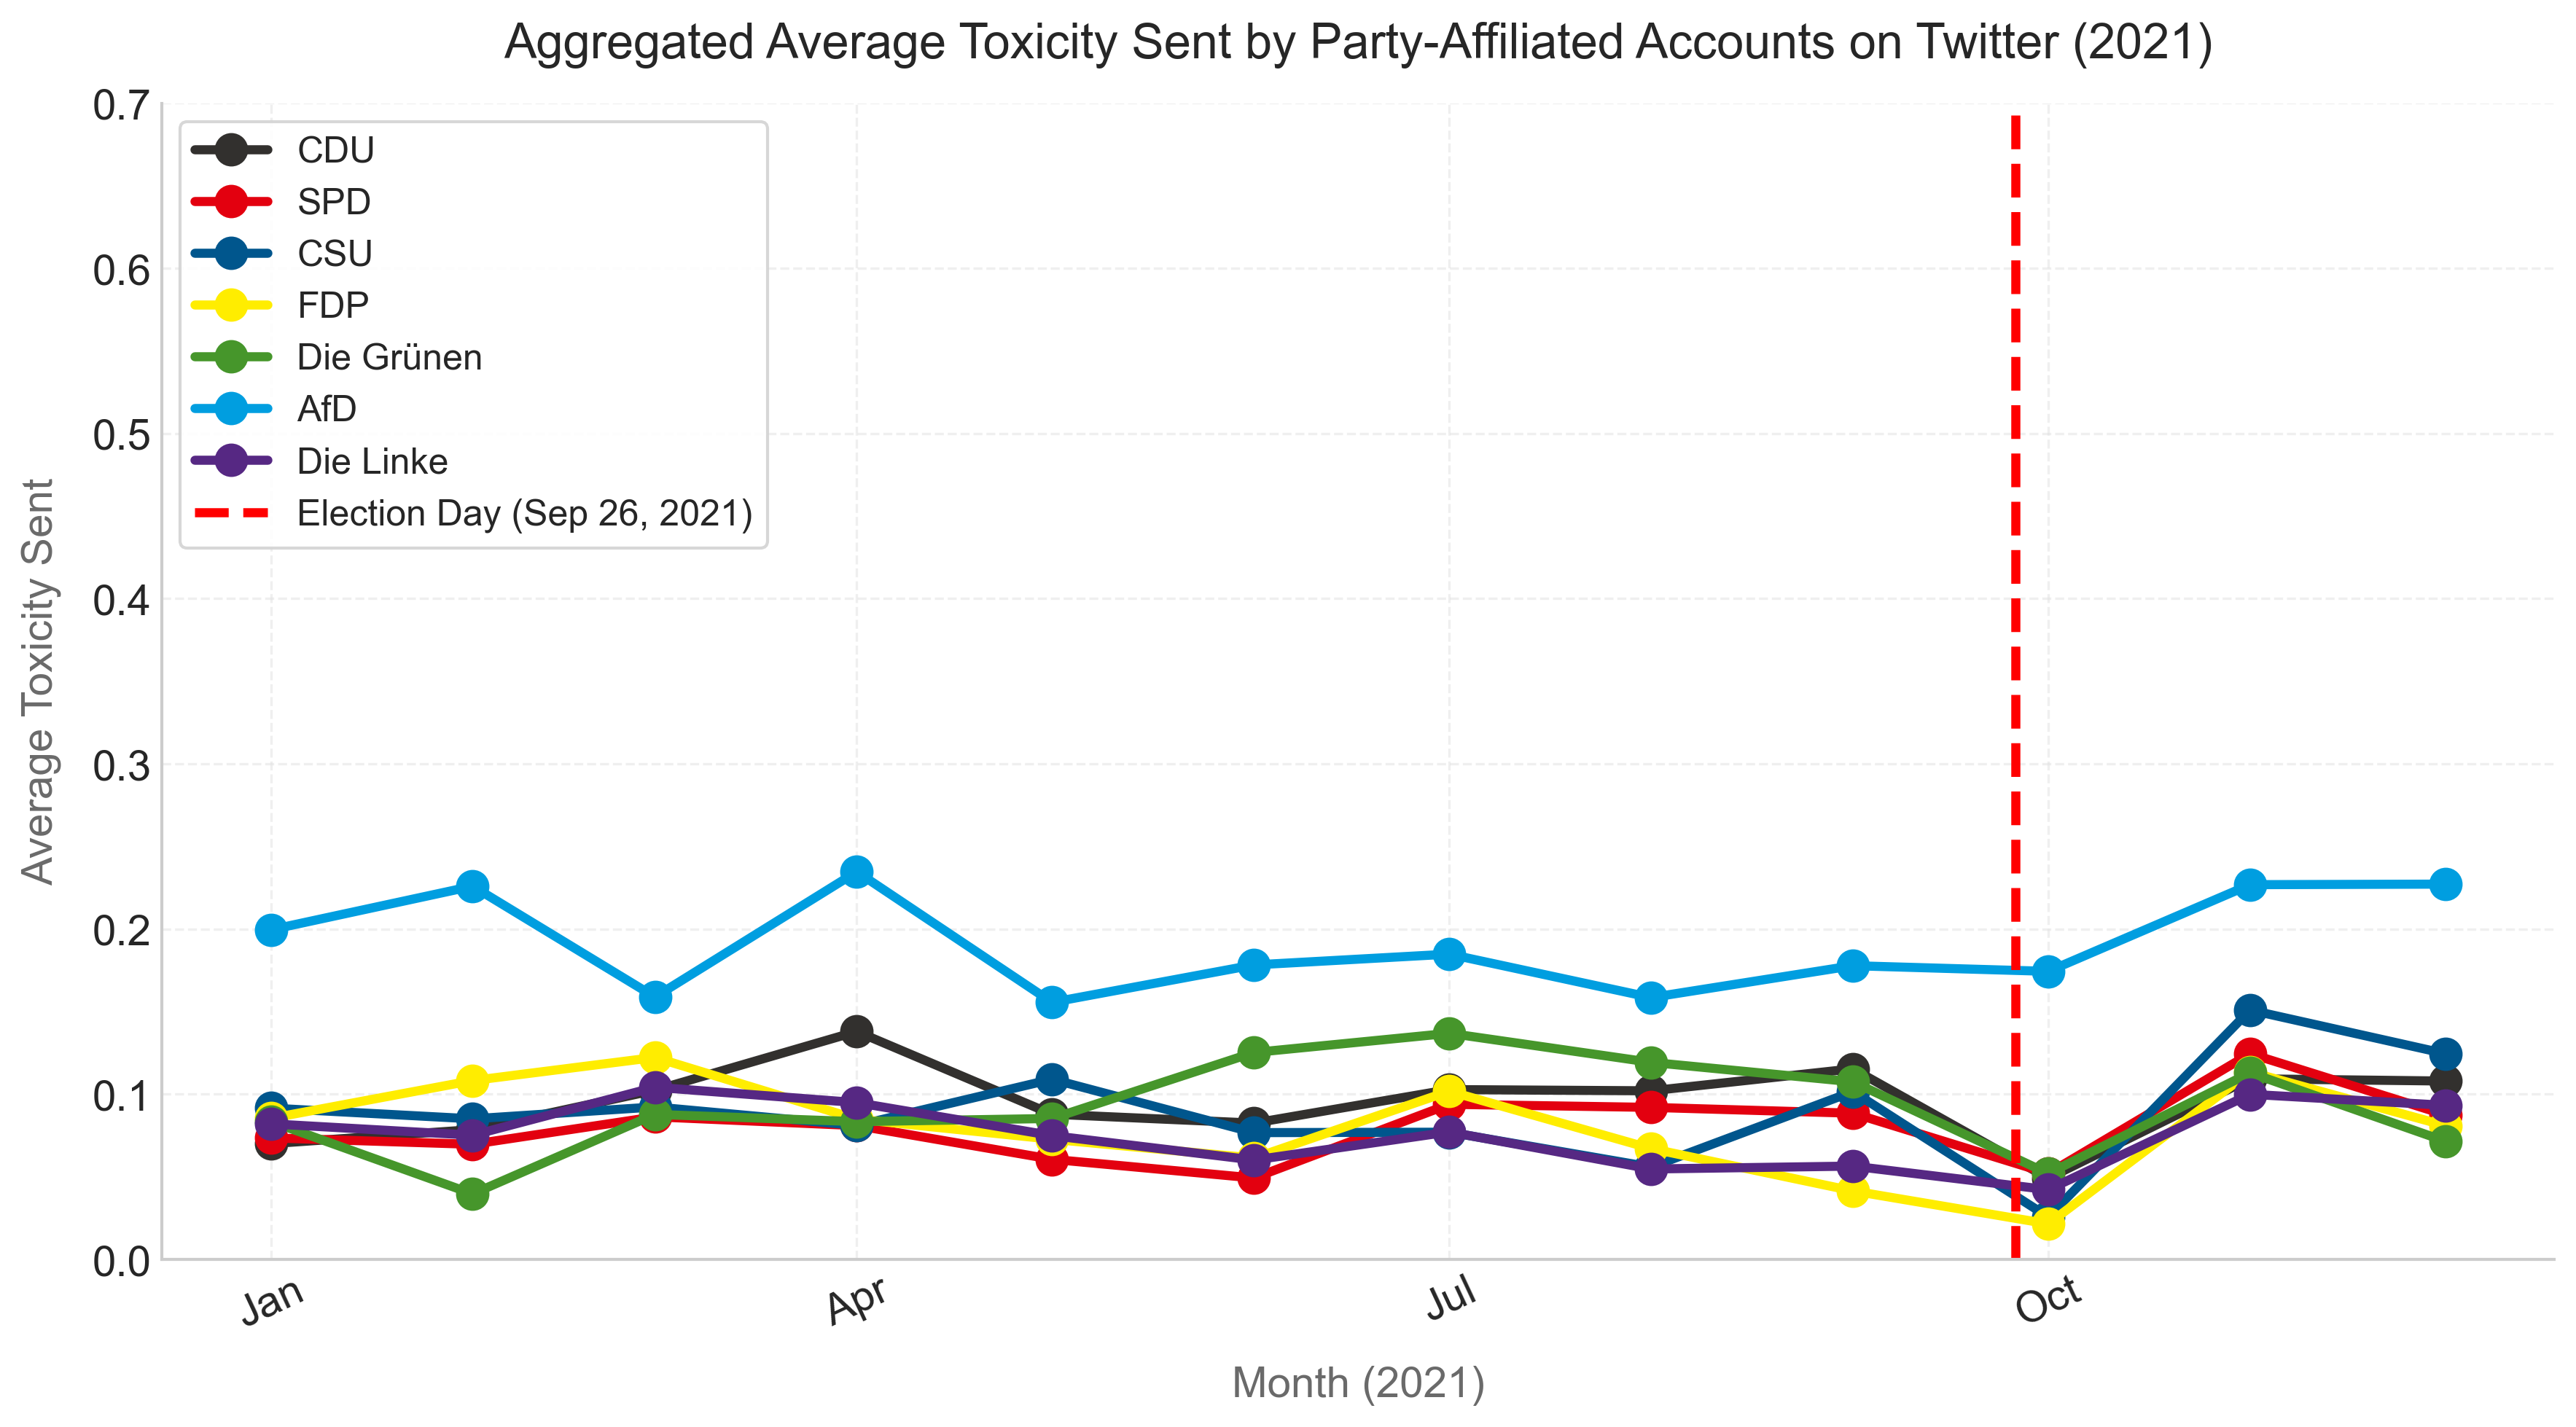

file_name aggregated_average_toxicity_received_by_party-affiliated_accounts_on_twitter_(2021).png


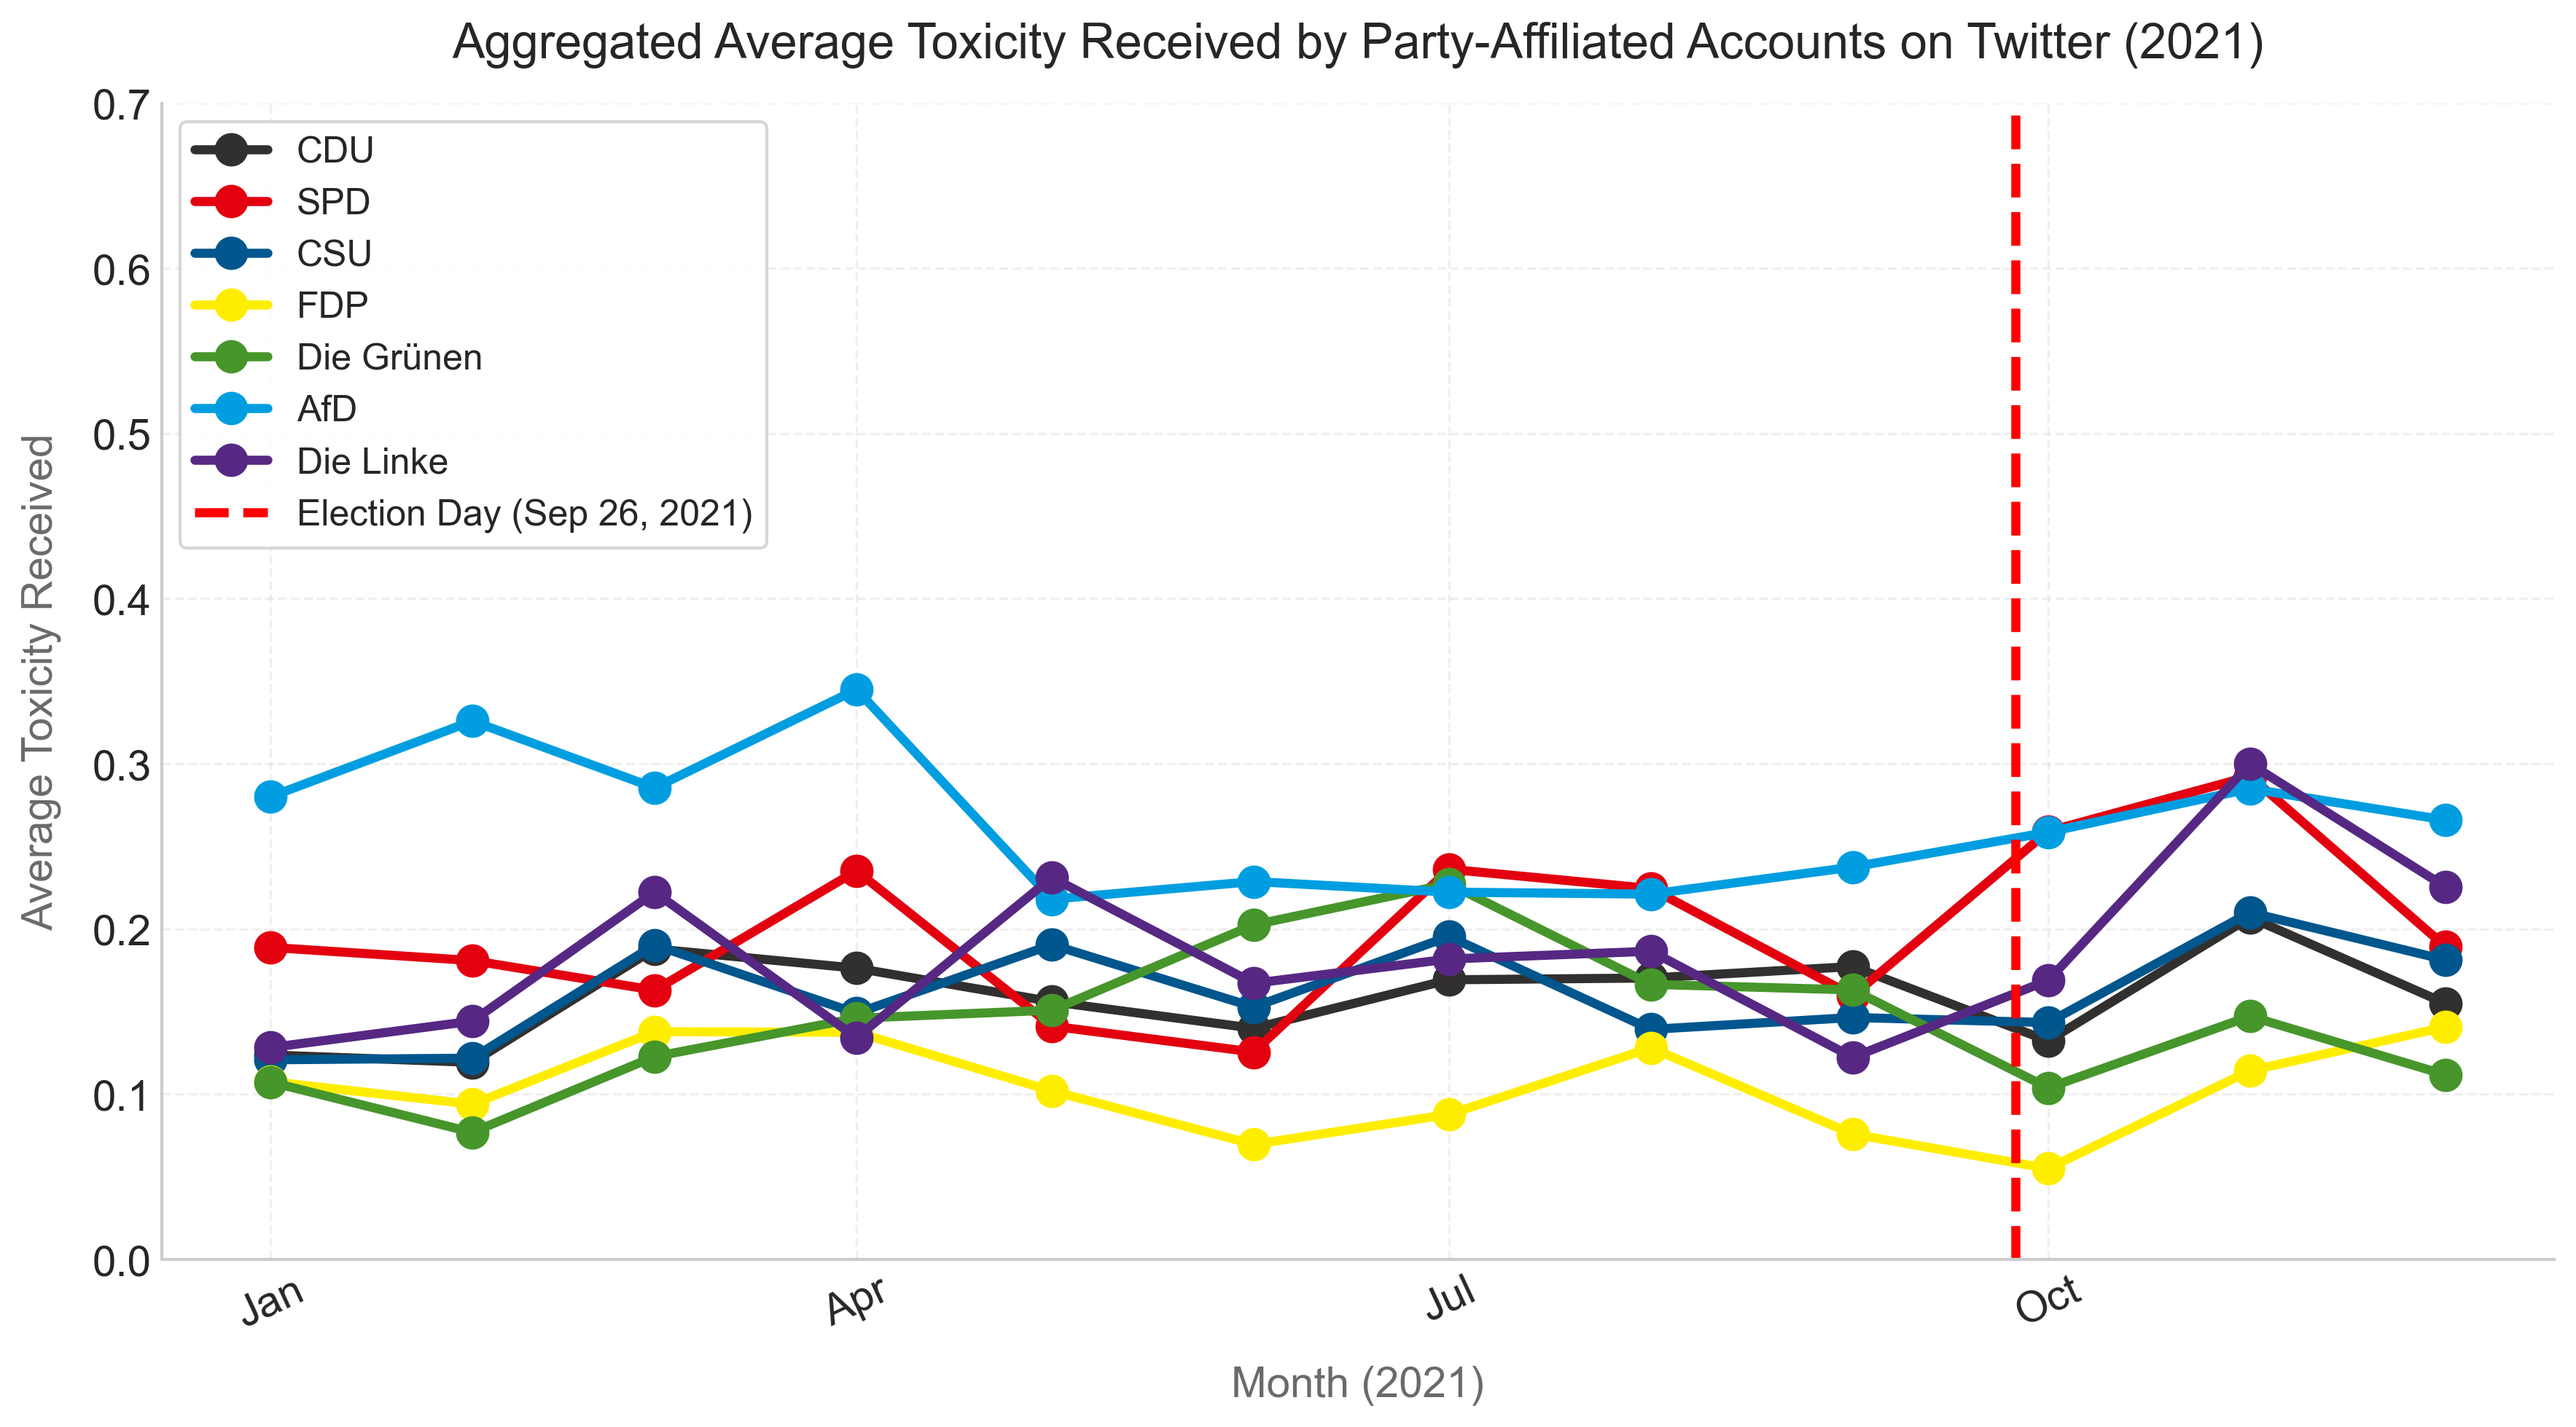

In [654]:
# Query toxicity metrics for specific German political party accounts for 2021 only
party_toxicity_query = """
SELECT 
    CAST(month_start AS STRING) as month_start_str,
    node_id,
    toxicity_sent_avg,
    toxicity_received_avg
FROM `grounded-nebula-408412.twitter_analysis_30_network_analysis.nodes_all`
WHERE node_id IN ('cdu', 'spdde', 'csu', 'fdp', 'die_gruenen', 'dielinke', 'afd')
  AND month_start >= '2021-01-01' 
  AND month_start < '2022-01-01'
ORDER BY month_start, node_id
"""

party_affiliation_toxicity_query = """
WITH
  filtered_nodes AS (
  SELECT
    month_start,
    CASE
      WHEN party = 'CDU' THEN 'cdu'
      WHEN party = 'SPD' THEN 'spdde'
      WHEN party = 'CSU' THEN 'csu'
      WHEN party = 'FDP' THEN 'fdp'
      WHEN party = 'Bündnis 90/Die Grünen' THEN 'die_gruenen'
      WHEN party = 'DIE LINKE' THEN 'dielinke'
      WHEN party = 'AfD' THEN 'afd'
  END AS node_id,
    toxicity_sent,
    toxicity_received,
    interactions_sent,
    interactions_received
  FROM `grounded-nebula-408412.twitter_analysis_30_network_analysis.nodes_all`
  WHERE party IN ('CDU', 'SPD', 'CSU', 'FDP', 'Bündnis 90/Die Grünen', 'DIE LINKE', 'AfD')
    AND month_start >= '2021-01-01'
    AND month_start < '2022-01-01' 
),
aggregated AS (
  SELECT
    CAST(month_start AS STRING) AS month_start_str,
    node_id,
    SAFE_DIVIDE(SUM(toxicity_sent), SUM(interactions_sent)) AS toxicity_sent_avg,
    SAFE_DIVIDE(SUM(toxicity_received), SUM(interactions_received)) AS toxicity_received_avg,
    SUM(interactions_sent) AS total_interactions_sent,
    SUM(interactions_received) AS total_interactions_received
  FROM filtered_nodes
  GROUP BY month_start_str, node_id
)
SELECT
  month_start_str,
  node_id,
  toxicity_sent_avg,
  toxicity_received_avg
FROM aggregated
ORDER BY month_start_str, node_id;
"""

# Run the queries
party_df = run_query(party_toxicity_query)
party_affiliation_df = run_query(party_affiliation_toxicity_query)

# Check if data is available
if party_df.empty or party_affiliation_df.empty:
    print("No data returned from query. Check permissions and table content.")
else:
    # Convert string date to datetime
    party_df["month_start"] = pd.to_datetime(party_df["month_start_str"])
    party_affiliation_df["month_start"] = pd.to_datetime(
        party_affiliation_df["month_start_str"])

    # Find the global maximum for both metrics
    global_max = max(party_df["toxicity_sent_avg"].max(),
                     party_df["toxicity_received_avg"].max(),
                     party_affiliation_df["toxicity_sent_avg"].max(),
                     party_affiliation_df["toxicity_received_avg"].max(
                     )) * 1.05  # Add 5% margin

    # Refactored function to create plots with utility functions
    def create_toxicity_plot(df, metric_name, y_label, title):
        fig, ax = plt.subplots(figsize=PLOT_FIGURE_SIZE)

        for party in COLOR_PARTY.keys():
            party_data = df[df["node_id"] == party]
            if not party_data.empty:
                ax.plot(
                    party_data["month_start"],
                    party_data[metric_name],
                    marker="o",
                    linewidth=LINE_WIDTH,
                    markersize=MARKER_SIZE,
                    color=COLOR_PARTY.get(party),
                    label=PARTY_NAMES.get(party, party),
                )

        # Format x-axis with quarterly major ticks
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())

        # Add election line
        add_election_line(ax)

        # Rotate x-axis labels
        plt.xticks(rotation=25)
        plt.subplots_adjust(bottom=0.15)

        # Apply standard formatting
        format_plot(
            ax,
            title=title,
            xlabel="Month (2021)",
            ylabel=y_label,
            ylim_start=0,
            # ylim_end=global_max,
            ylim_end=0.7,
            legend_loc=LEGEND_POSITION)

        # plt.show()
        plt.tight_layout()

        file_safe_name = title.replace(" ", "_").lower()
        file_name = f'{file_safe_name}.png'
        print("file_name", file_name)
        plt.savefig(os.path.join(OUTPUT_DIR, file_name),
                    dpi=PLOT_DPI,
                    bbox_inches='tight')
        plt.show()

    # Create and display plots for both queries
    create_toxicity_plot(
        party_df, "toxicity_sent_avg", "Average Toxicity Sent",
        "Average Toxicity Sent by Official German Political Party Accounts on Twitter (2021)"
    )

    create_toxicity_plot(
        party_df, "toxicity_received_avg", "Average Toxicity Received",
        "Average Toxicity Received by Official German Political Party Accounts on Twitter (2021)"
    )

    create_toxicity_plot(
        party_affiliation_df, "toxicity_sent_avg", "Average Toxicity Sent",
        "Aggregated Average Toxicity Sent by Party-Affiliated Accounts on Twitter (2021)"
    )

    create_toxicity_plot(
        party_affiliation_df, "toxicity_received_avg",
        "Average Toxicity Received",
        "Aggregated Average Toxicity Received by Party-Affiliated Accounts on Twitter (2021)"
    )


# Descriptive Statistics (Section 4.1)
## 4.1.1 Distribution of Toxic Language in Political Discourse

Let's examine the distribution of toxicity scores at both tweet and user levels to understand 
how toxic language is distributed across the political discourse during the 2021 German Federal Election.

In [655]:
# Import necessary libraries
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import pandas as pd
from datetime import datetime

# Set style
plt.rcParams.update({
    'font.family': FONT_FAMILY,
    'font.sans-serif': FONT_NAMES,
    'font.size': DEFAULT_FONT_SIZE,
    'font.weight': FONT_WEIGHT,
    'figure.dpi': PLOT_DPI,
    'axes.titlesize': TITLE_FONT_SIZE,
    'axes.labelsize': AXIS_FONT_SIZE,
    'axes.titleweight': FONT_TITLE_WEIGHT,
    'xtick.labelsize': DEFAULT_FONT_SIZE,
    'ytick.labelsize': DEFAULT_FONT_SIZE,
    'legend.fontsize': LEGEND_FONT_SIZE,
    'figure.figsize': PLOT_FIGURE_SIZE,
})

# Query to get tweet-level toxicity distribution with rounding
tweet_toxicity_query = """
SELECT 
    ROUND(toxicity_score, 2) AS toxicity_score,
    COUNT(*) AS count
FROM `grounded-nebula-408412.twitter_analysis_20_curated.tweets_relevant_with_predictions`
WHERE 
    toxicity_score IS NOT NULL 
    AND toxicity_score BETWEEN 0 AND 1
GROUP BY ROUND(toxicity_score, 2)
ORDER BY ROUND(toxicity_score, 2)
"""

# Query for user-level average toxicity - computed in BigQuery with rounding
user_toxicity_query = """
WITH user_toxicity AS (
    SELECT 
        user_id,
        ROUND(AVG(toxicity_score), 2) AS avg_toxicity,
        COUNT(toxicity_score) AS tweet_count
    FROM `grounded-nebula-408412.twitter_analysis_20_curated.tweets_relevant_with_predictions`
    WHERE
        toxicity_score IS NOT NULL 
        AND toxicity_score BETWEEN 0 AND 1
    GROUP BY user_id
    HAVING COUNT(toxicity_score) >= 5
)
SELECT 
    avg_toxicity,
    COUNT(*) AS user_count
FROM user_toxicity
GROUP BY avg_toxicity
ORDER BY avg_toxicity
"""

# Run the queries
tweet_toxicity_grouped = run_query(tweet_toxicity_query)
user_toxicity_grouped = run_query(user_toxicity_query)

Query executed successfully. Retrieved 101 rows.
Columns: ['toxicity_score', 'count']
Query executed successfully. Retrieved 101 rows.
Columns: ['avg_toxicity', 'user_count']


In [656]:
# Calculate statistics from the grouped data
tweet_mean = np.average(tweet_toxicity_grouped['toxicity_score'], 
                        weights=tweet_toxicity_grouped['count'])
tweet_median = np.median(np.repeat(tweet_toxicity_grouped['toxicity_score'], 
                                   tweet_toxicity_grouped['count']))
tweet_std = np.sqrt(np.average((tweet_toxicity_grouped['toxicity_score'] - tweet_mean)**2, 
                              weights=tweet_toxicity_grouped['count']))
tweet_max = tweet_toxicity_grouped['toxicity_score'].max()
tweet_count = tweet_toxicity_grouped['count'].sum()

user_mean = np.average(user_toxicity_grouped['avg_toxicity'], 
                       weights=user_toxicity_grouped['user_count'])
user_median = np.median(np.repeat(user_toxicity_grouped['avg_toxicity'], 
                                 user_toxicity_grouped['user_count']))
user_std = np.sqrt(np.average((user_toxicity_grouped['avg_toxicity'] - user_mean)**2, 
                             weights=user_toxicity_grouped['user_count']))
user_max = user_toxicity_grouped['avg_toxicity'].max()
user_count = user_toxicity_grouped['user_count'].sum()

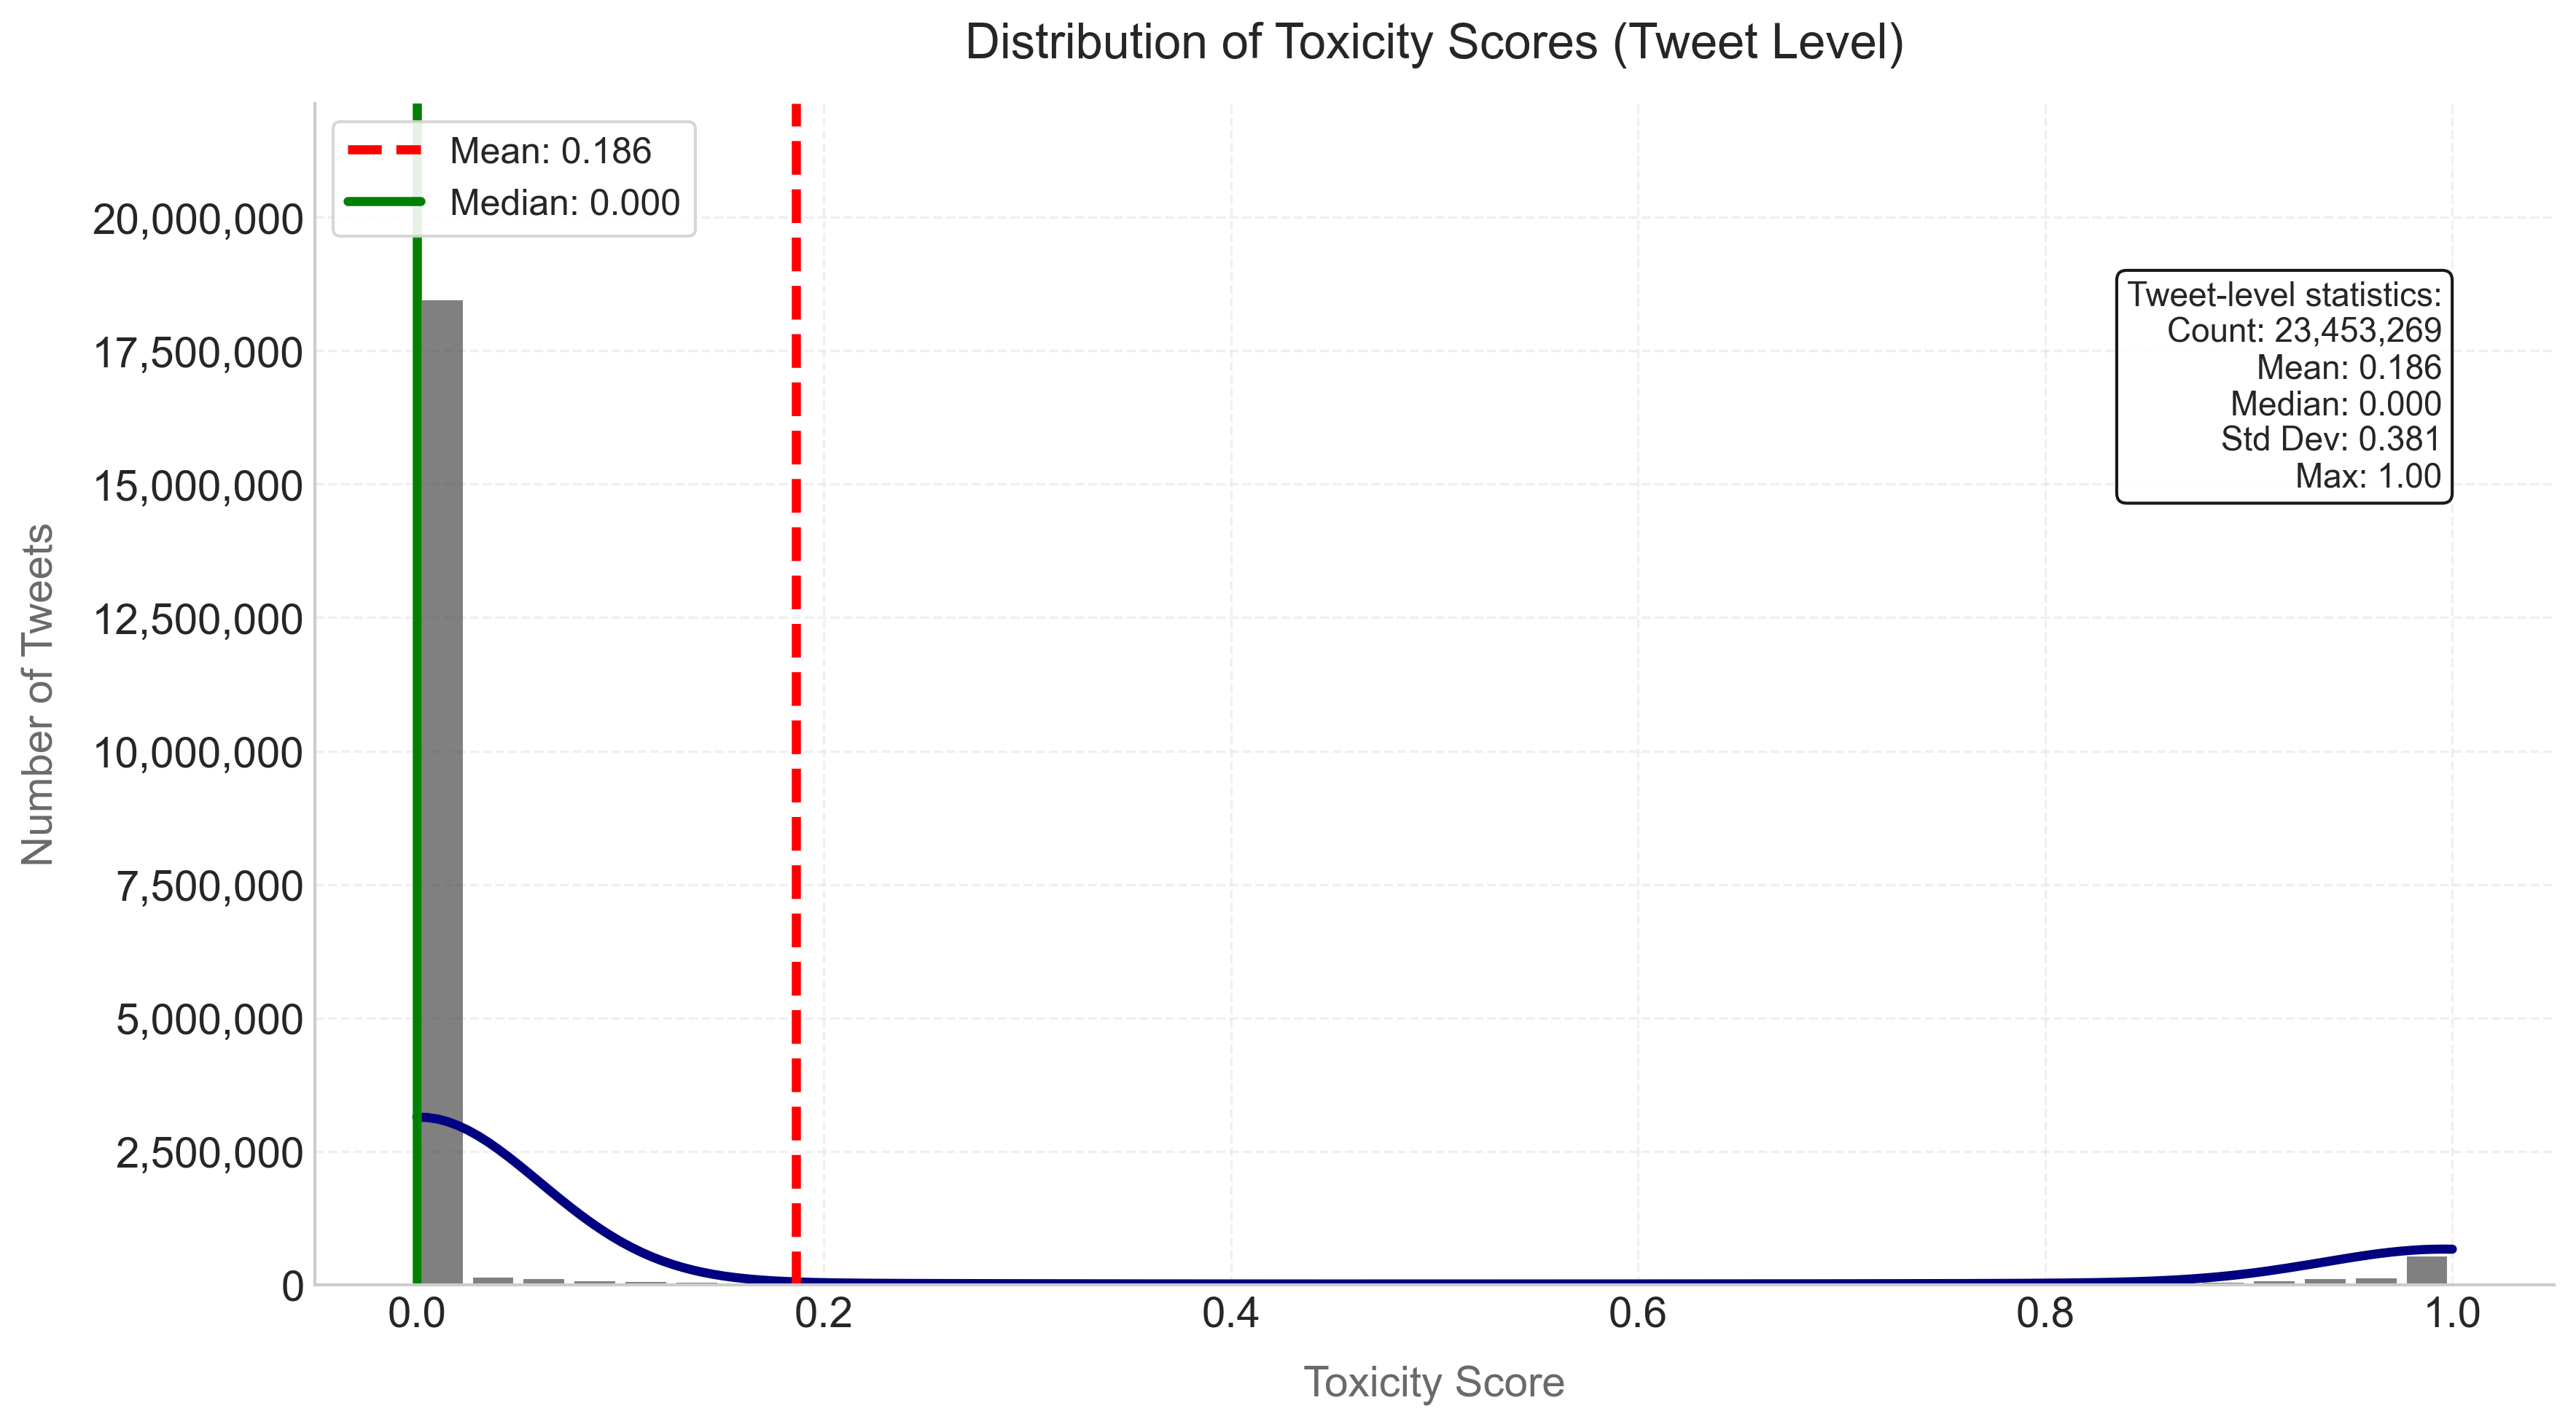

In [657]:
# Create separate histogram for tweet-level toxicity - refactored with format_plot
fig, ax = plt.subplots(figsize=PLOT_FIGURE_SIZE)

# Prepare histogram data - convert to bin frequencies for better control
bins = np.linspace(0, 1, 41)  # 40 bins from 0 to 1
bin_centers = (bins[:-1] + bins[1:]) / 2

hist_data = np.zeros(len(bin_centers))
for score, count in zip(tweet_toxicity_grouped['toxicity_score'], tweet_toxicity_grouped['count']):
    bin_idx = np.digitize(score, bins) - 1
    if 0 <= bin_idx < len(hist_data):
        hist_data[bin_idx] += count

# Histogram plot
ax.bar(bin_centers, hist_data, width=(bins[1]-bins[0])*0.8, color=colors[0], alpha=0.7)

# Add a KDE curve - Use a simpler approach to avoid memory issues
from scipy import stats
x = np.linspace(0, 1, 200)
kde = stats.gaussian_kde(
    tweet_toxicity_grouped['toxicity_score'],
    weights=tweet_toxicity_grouped['count']/tweet_toxicity_grouped['count'].sum(),
    bw_method=0.1  # Adjust bandwidth for smoother curve
)
kde_y = kde(x) * tweet_count * (bins[1]-bins[0])  # Scale to match histogram
ax.plot(x, kde_y, color='navy', linewidth=LINE_WIDTH)

# Add vertical lines for mean and median
ax.axvline(x=tweet_mean, color='red', linestyle='--', linewidth=LINE_WIDTH,
            label=f'Mean: {tweet_mean:.3f}')
ax.axvline(x=tweet_median, color='green', linestyle='-', linewidth=LINE_WIDTH,
           label=f'Median: {tweet_median:.3f}')

# Format y-axis with comma separators
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

# Add summary statistics as text
tweet_stats = (
    f"Tweet-level statistics:\n"
    f"Count: {tweet_count:,}\n"
    f"Mean: {tweet_mean:.3f}\n"
    f"Median: {tweet_median:.3f}\n"
    f"Std Dev: {tweet_std:.3f}\n"
    f"Max: {tweet_max:.2f}"
)

# Add text box with statistics
ax.text(0.95, 0.85, tweet_stats, transform=ax.transAxes, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=LEGEND_FRAME_ALPHA),
         fontsize=11)

# Apply standard formatting
format_plot(
    ax,
    title='Distribution of Toxicity Scores (Tweet Level)',
    xlabel='Toxicity Score',
    ylabel='Number of Tweets',
    ylim_start=0, 
    ylim_end=hist_data.max() * 1.2,  # Add 20% margin at top
    legend_loc=LEGEND_POSITION, 
)



plt.tight_layout()
file_name = 'toxicity_distribution_tweets.png'
plt.savefig(os.path.join(OUTPUT_DIR, file_name) , dpi=PLOT_DPI, bbox_inches='tight')
plt.show()
plt.close()

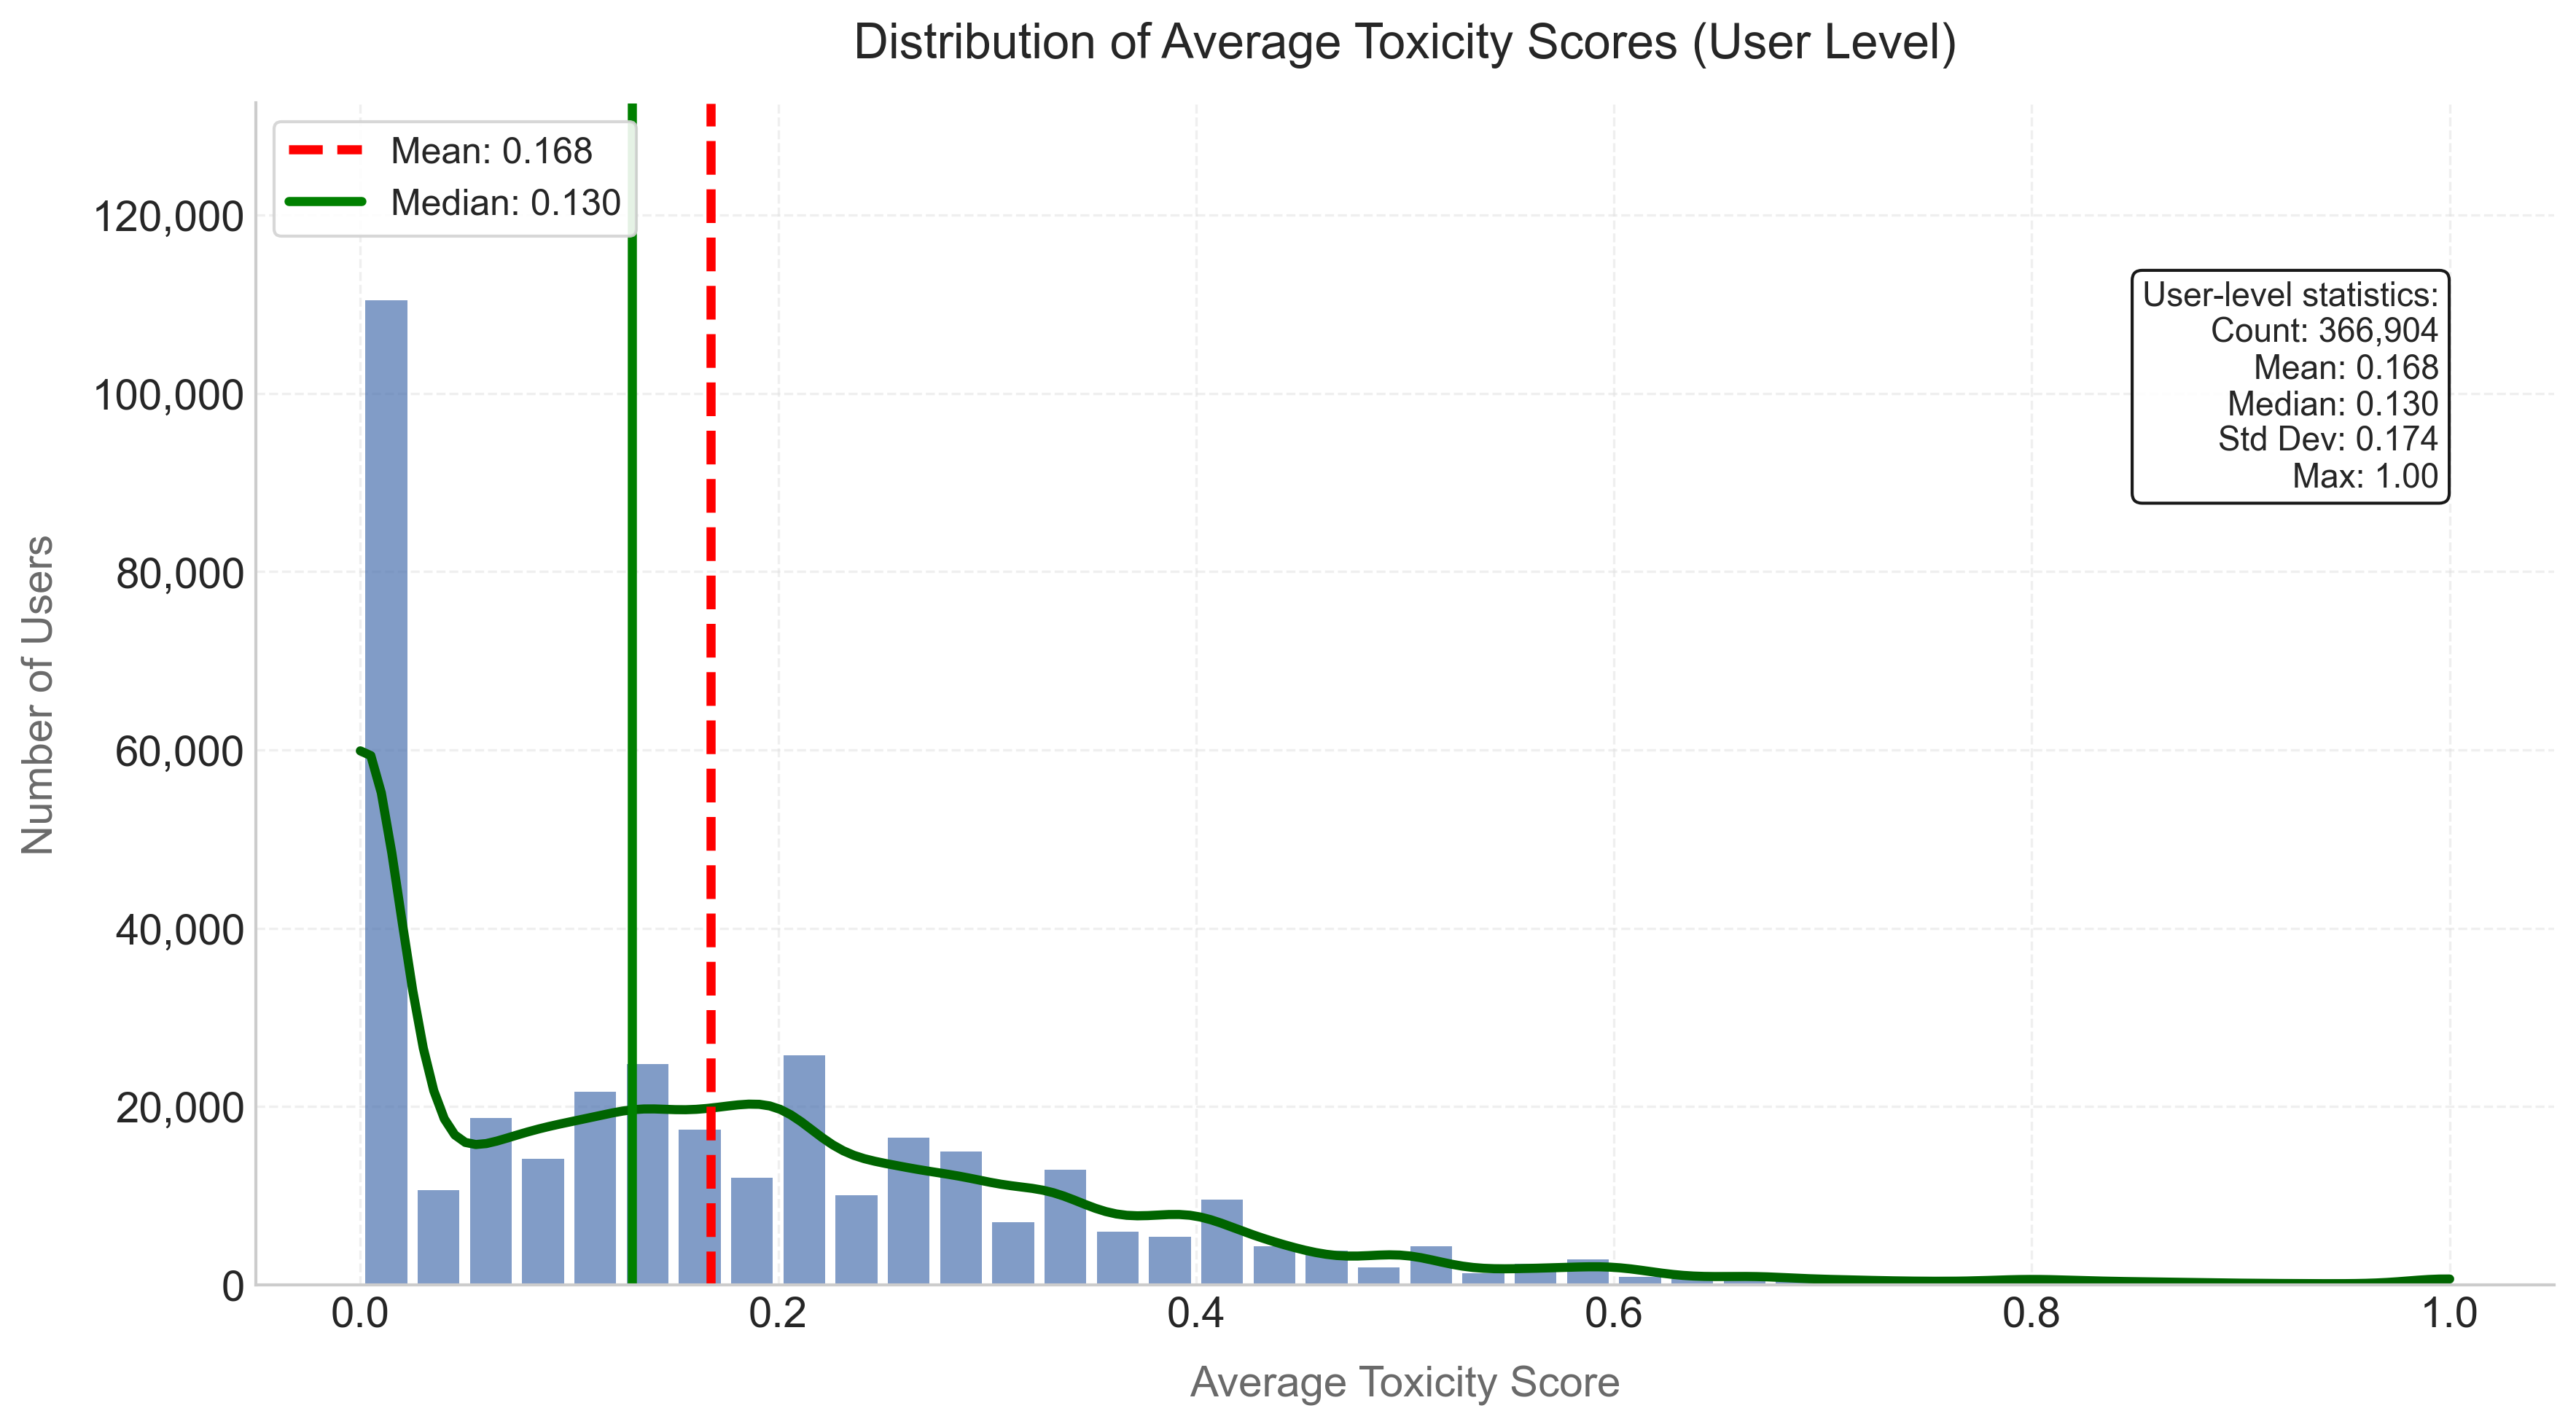

In [658]:
# Create separate histogram for user-level toxicity - refactored with format_plot
fig, ax = plt.subplots(figsize=PLOT_FIGURE_SIZE)

# Prepare histogram data
bins = np.linspace(0, 1, 41)  # 40 bins from 0 to 1
bin_centers = (bins[:-1] + bins[1:]) / 2

hist_data = np.zeros(len(bin_centers))
for score, count in zip(user_toxicity_grouped['avg_toxicity'], user_toxicity_grouped['user_count']):
    bin_idx = np.digitize(score, bins) - 1
    if 0 <= bin_idx < len(hist_data):
        hist_data[bin_idx] += count

# Histogram plot
ax.bar(bin_centers, hist_data, width=(bins[1]-bins[0])*0.8, color=colors[1], alpha=0.7)

# Add a KDE curve - Use a simpler approach
kde = stats.gaussian_kde(
    user_toxicity_grouped['avg_toxicity'],
    weights=user_toxicity_grouped['user_count']/user_toxicity_grouped['user_count'].sum(),
    bw_method=0.1  # Adjust bandwidth for smoother curve
)
x = np.linspace(0, 1, 200)
kde_y = kde(x) * user_count * (bins[1]-bins[0])  # Scale to match histogram
ax.plot(x, kde_y, color='darkgreen', linewidth=LINE_WIDTH)

# Add vertical lines for mean and median
ax.axvline(x=user_mean, color='red', linestyle='--', linewidth=LINE_WIDTH,
            label=f'Mean: {user_mean:.3f}')
ax.axvline(x=user_median, color='green', linestyle='-', linewidth=LINE_WIDTH,
           label=f'Median: {user_median:.3f}')

# Format y-axis with comma separators
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

# Add summary statistics as text
user_stats = (
    f"User-level statistics:\n"
    f"Count: {user_count:,}\n"
    f"Mean: {user_mean:.3f}\n"
    f"Median: {user_median:.3f}\n"
    f"Std Dev: {user_std:.3f}\n"
    f"Max: {user_max:.2f}"
)

# Add text box with statistics
ax.text(0.95, 0.85, user_stats, transform=ax.transAxes, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=LEGEND_FRAME_ALPHA),
         fontsize=11)

# Apply standard formatting
format_plot(
    ax,
    title='Distribution of Average Toxicity Scores (User Level)',
    xlabel='Average Toxicity Score',
    ylabel='Number of Users',
    ylim_start=0, 
    ylim_end=hist_data.max() * 1.2,  # Add 20% margin at top
    legend_loc=LEGEND_POSITION
)

plt.tight_layout()
file_name = 'toxicity_distribution_users.png'
plt.savefig(os.path.join(OUTPUT_DIR, file_name) , dpi=PLOT_DPI, bbox_inches='tight')
plt.show()
plt.close()  # Close the figure to free memory

### Toxicity Buckets Analysis

To better understand the distribution of toxicity, we'll categorize tweets and users into toxicity buckets.

In [659]:
# Get bucket distributions directly from BigQuery
bucket_query = """
WITH tweet_buckets AS (
    SELECT
        CASE
            WHEN toxicity_score < 0.2 THEN 'Very Low'
            WHEN toxicity_score < 0.4 THEN 'Low'
            WHEN toxicity_score < 0.6 THEN 'Moderate'
            WHEN toxicity_score < 0.8 THEN 'High'
            ELSE 'Very High'
        END AS bucket,
        COUNT(*) AS tweet_count
    FROM `grounded-nebula-408412.twitter_analysis_20_curated.tweets_relevant_with_predictions`
    WHERE
        toxicity_score IS NOT NULL 
        AND toxicity_score BETWEEN 0 AND 1
    GROUP BY bucket
),
user_avg_toxicity AS (
    SELECT
        user_id,
        AVG(toxicity_score) AS avg_toxicity
    FROM `grounded-nebula-408412.twitter_analysis_20_curated.tweets_relevant_with_predictions`
    WHERE
        toxicity_score IS NOT NULL 
        AND toxicity_score BETWEEN 0 AND 1
    GROUP BY user_id
    HAVING COUNT(*) >= 5  -- Optional: filter to users with minimum activity
),
user_buckets AS (
    SELECT
        CASE
            WHEN avg_toxicity < 0.2 THEN 'Very Low'
            WHEN avg_toxicity < 0.4 THEN 'Low'
            WHEN avg_toxicity < 0.6 THEN 'Moderate'
            WHEN avg_toxicity < 0.8 THEN 'High'
            ELSE 'Very High'
        END AS bucket,
        COUNT(*) AS user_count
    FROM user_avg_toxicity
    GROUP BY bucket
)
SELECT
    t.bucket,
    t.tweet_count,
    ROUND(t.tweet_count * 100.0 / (SELECT SUM(tweet_count) FROM tweet_buckets), 1) AS tweet_percentage,
    u.user_count,
    ROUND(u.user_count * 100.0 / (SELECT SUM(user_count) FROM user_buckets), 1) AS user_percentage
FROM tweet_buckets t
JOIN user_buckets u ON t.bucket = u.bucket
ORDER BY CASE t.bucket
    WHEN 'Very Low' THEN 1
    WHEN 'Low' THEN 2
    WHEN 'Moderate' THEN 3
    WHEN 'High' THEN 4
    WHEN 'Very High' THEN 5
END
"""

bucket_df = run_query(bucket_query)
bucket_df = bucket_df.rename(columns={
    'tweet_count': 'Tweet Count',
    'tweet_percentage': 'Tweet %',
    'user_count': 'User Count',
    'user_percentage': 'User %'
})

print(bucket_df)

Query executed successfully. Retrieved 5 rows.
Columns: ['bucket', 'tweet_count', 'tweet_percentage', 'user_count', 'user_percentage']
      bucket  Tweet Count  Tweet %  User Count  User %
0   Very Low     18885350     80.5      234546    63.9
1        Low       147669      0.6       96656    26.3
2   Moderate       109421      0.5       27032     7.4
3       High       138360      0.6        5904     1.6
4  Very High      4172469     17.8        2766     0.8


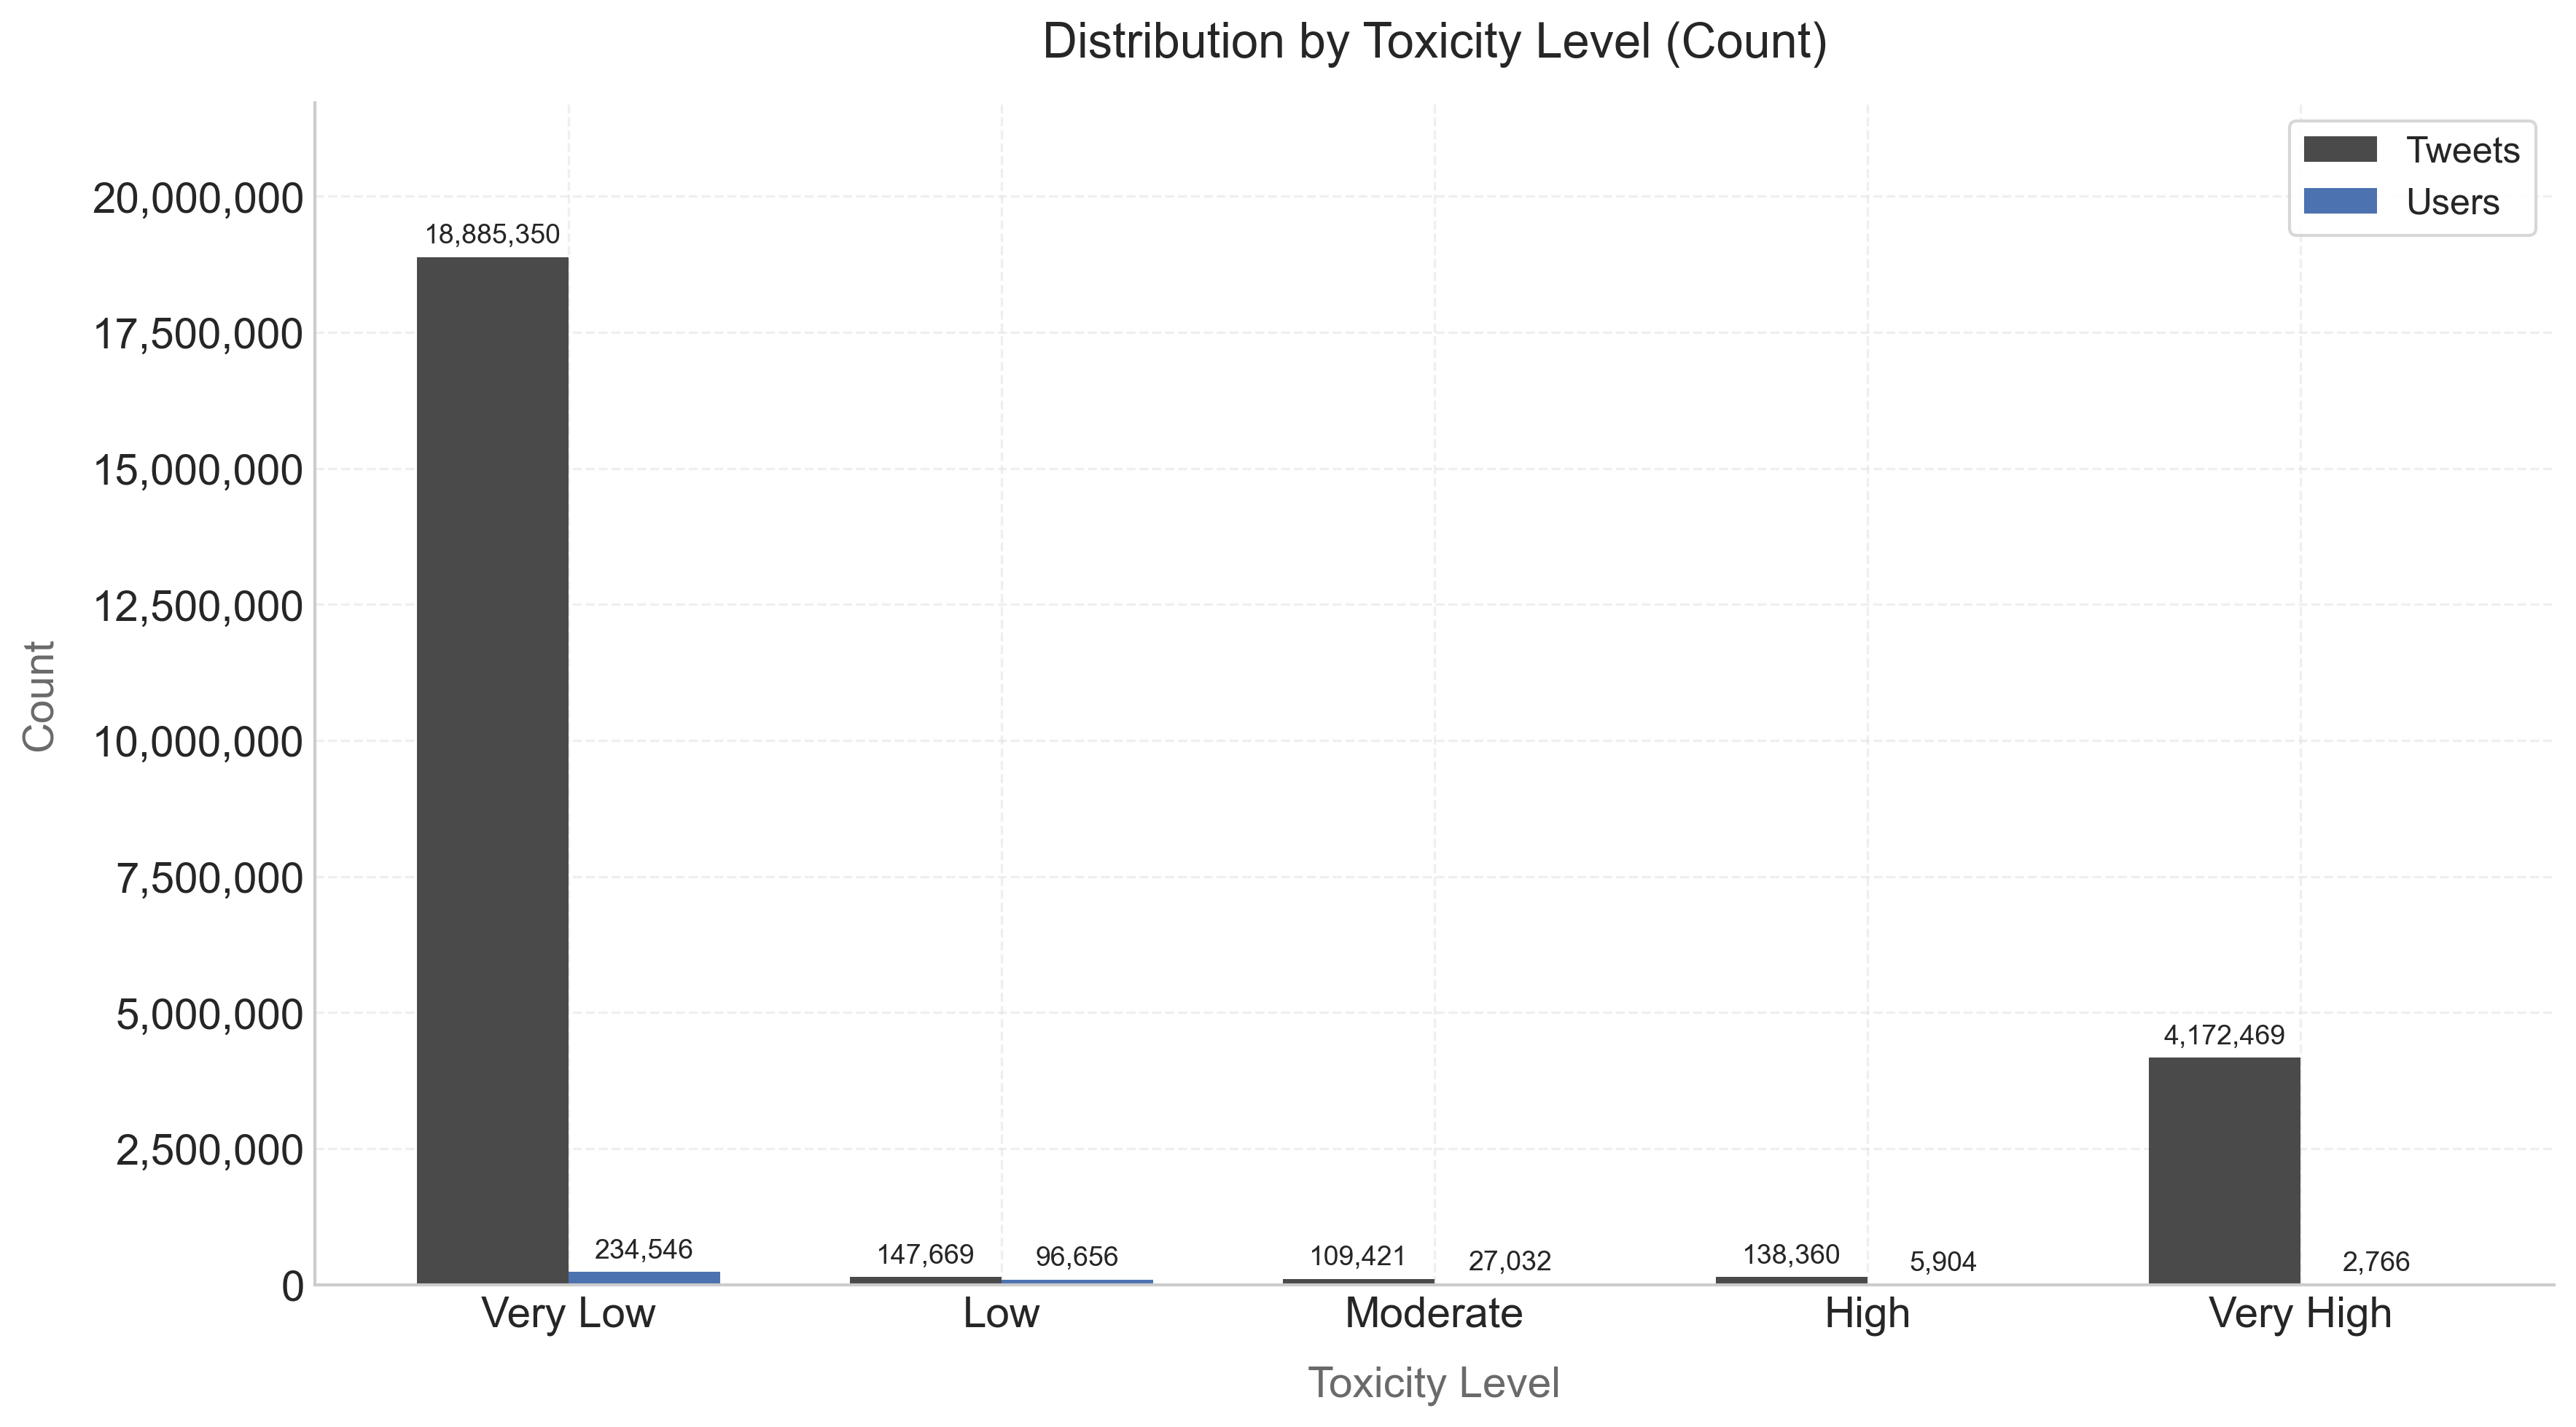

In [660]:
# Create count distribution chart - refactored with format_plot
fig, ax = plt.subplots(figsize=PLOT_FIGURE_SIZE)

# Tweet-level bucket distribution
x = np.arange(len(bucket_df['bucket']))
bar_width = 0.35

# Format with commas for thousands
def format_with_commas(val, pos):
    return f'{val:,.0f}'

formatter = plt.matplotlib.ticker.FuncFormatter(format_with_commas)

# Tweet count bar chart
bars1 = ax.bar(x - bar_width/2, bucket_df['Tweet Count'], bar_width, color=colors[0],
               label='Tweets')
bars2 = ax.bar(x + bar_width/2, bucket_df['User Count'], bar_width, color=colors[1],
               label='Users')

# Add value labels above bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:,.0f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(bucket_df['bucket'])
ax.yaxis.set_major_formatter(formatter)

# Apply standard formatting
format_plot(
    ax,
    title='Distribution by Toxicity Level (Count)',
    xlabel='Toxicity Level',
    ylabel='Count',
    ylim_start=0, 
    ylim_end=max(bucket_df['Tweet Count'].max(), bucket_df['User Count'].max()) * 1.15,
    legend_loc="upper right"
)

plt.tight_layout()
file_name = 'toxicity_buckets_count.png'
plt.savefig(os.path.join(OUTPUT_DIR, file_name) , dpi=PLOT_DPI, bbox_inches='tight')
plt.show()
plt.close()

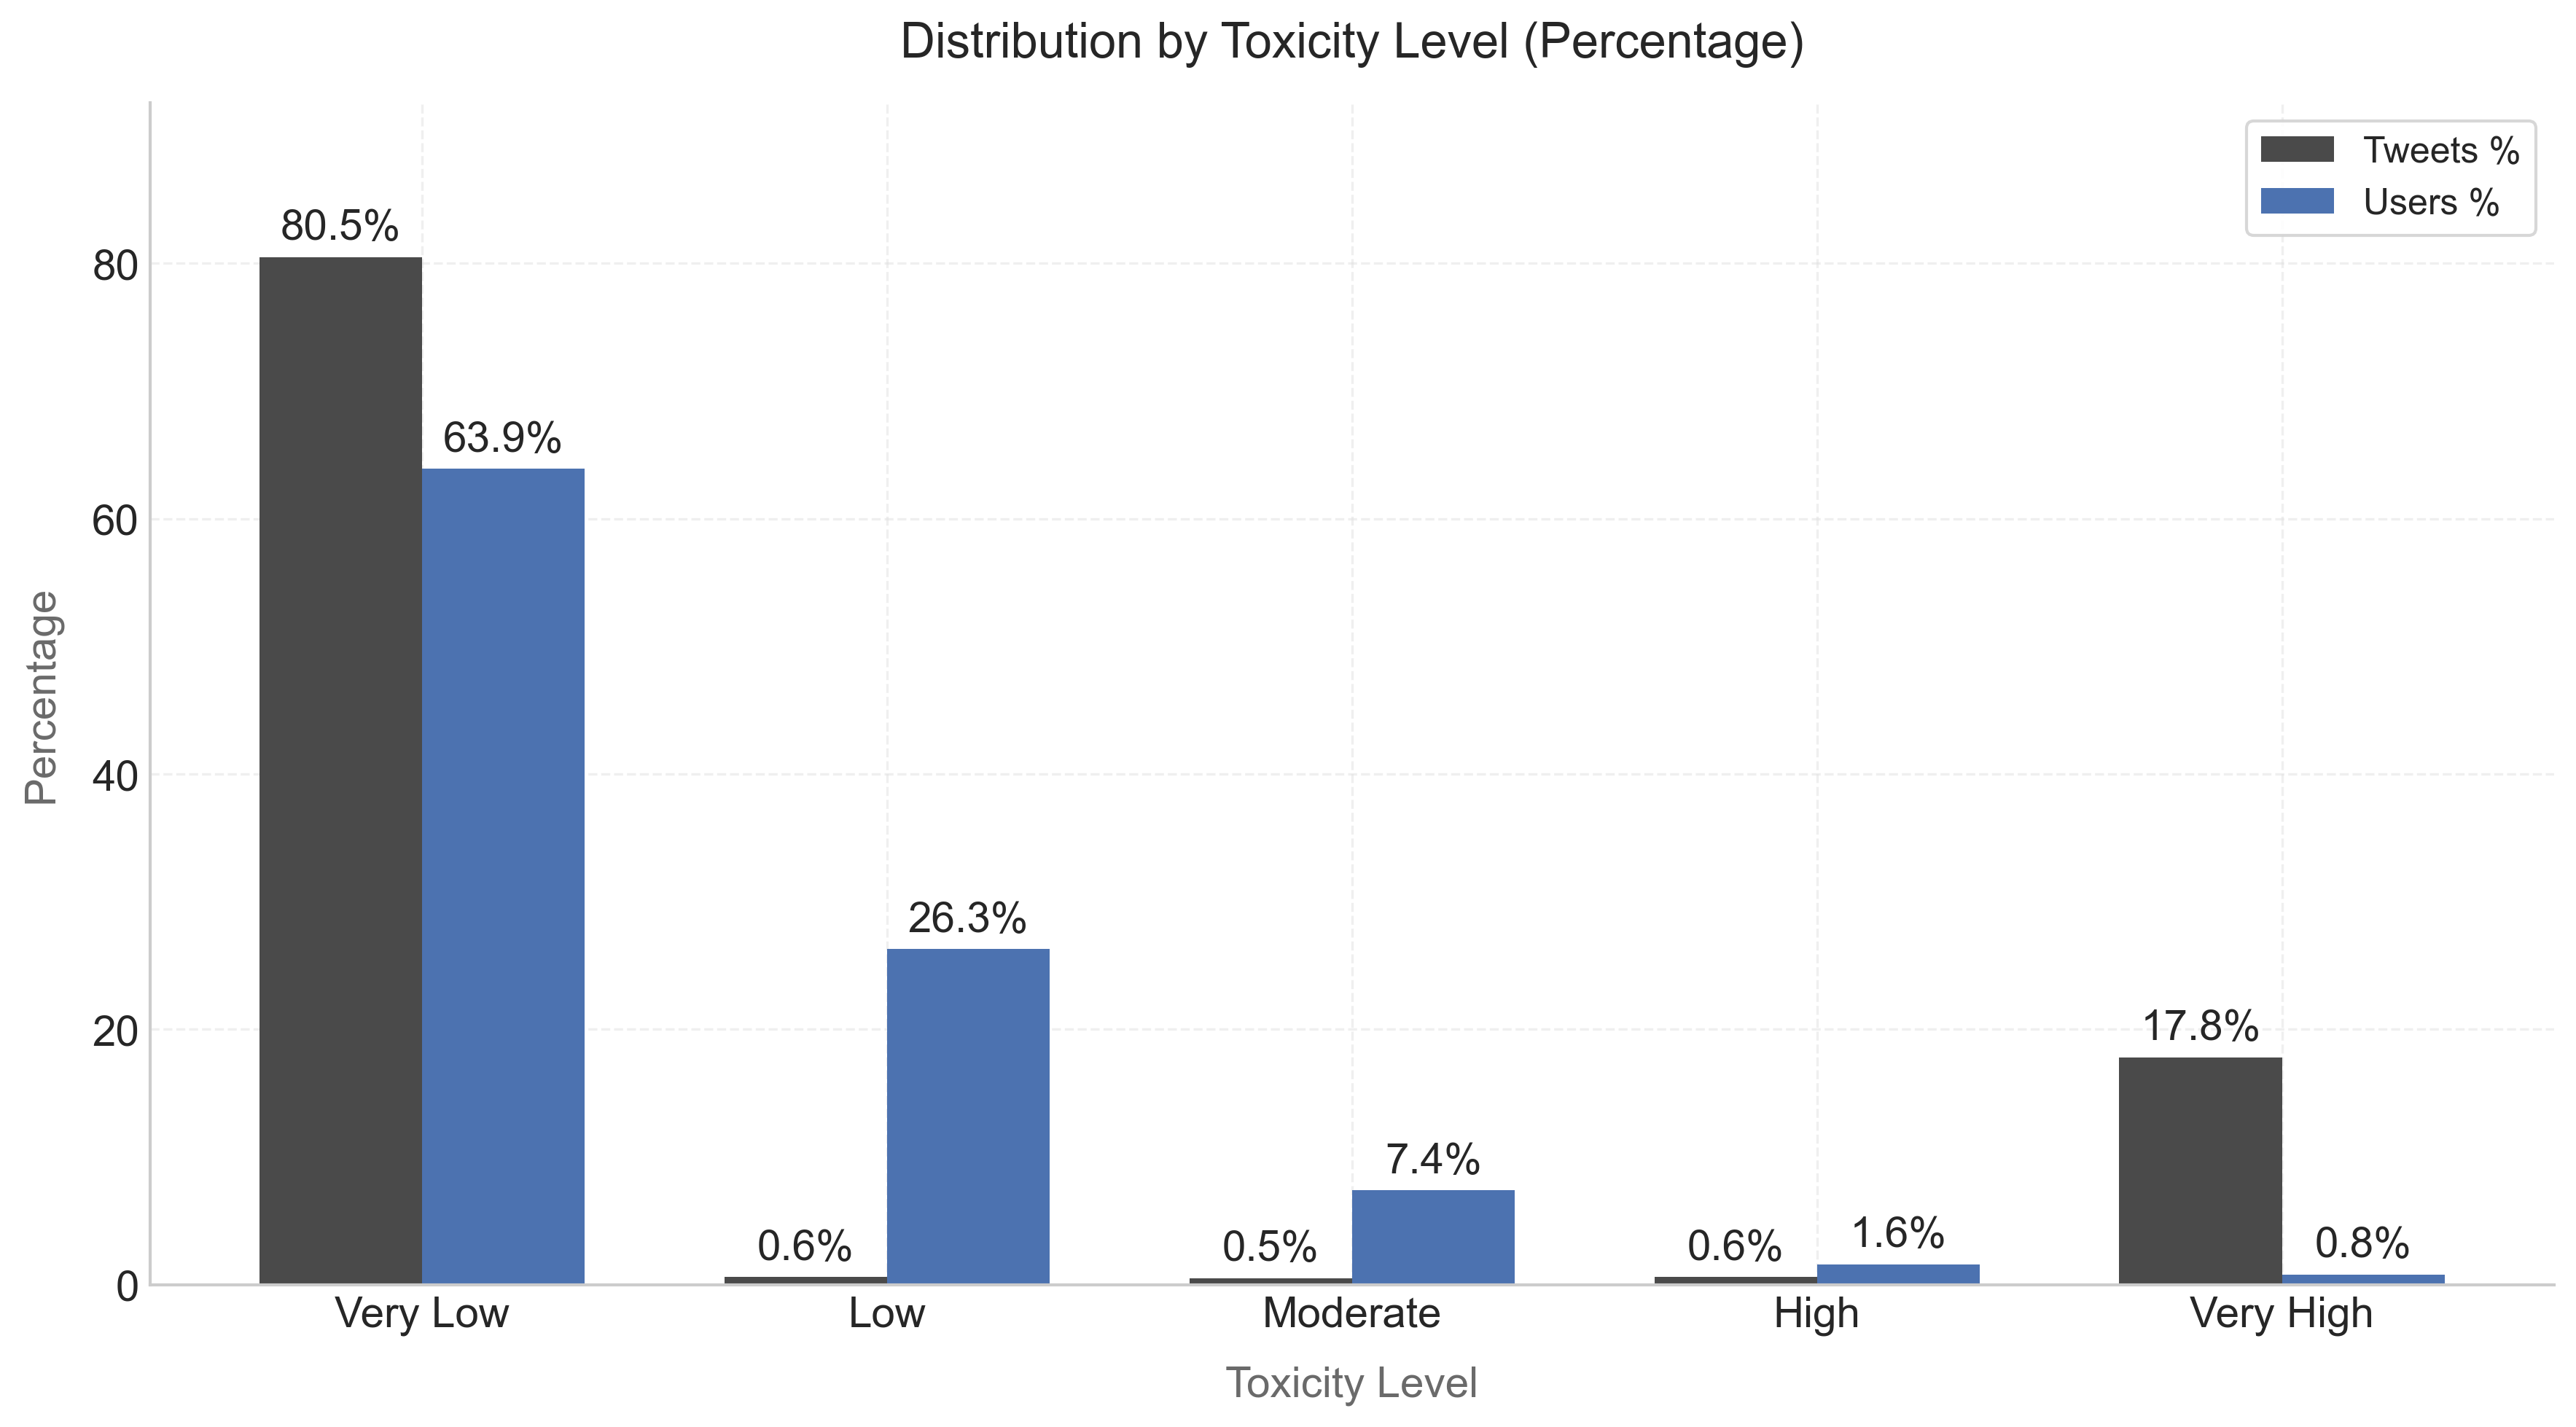

In [661]:
# Create percentage distribution chart - refactored with format_plot
fig, ax = plt.subplots(figsize=PLOT_FIGURE_SIZE)

# Tweet-level bucket distribution
x = np.arange(len(bucket_df['bucket']))
bar_width = 0.35

# Second subplot for percentages
bars3 = ax.bar(x - bar_width/2, bucket_df['Tweet %'], bar_width, color=colors[0],
               label='Tweets %')
bars4 = ax.bar(x + bar_width/2, bucket_df['User %'], bar_width, color=colors[1],
               label='Users %')

# Add value labels above bars
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=BASE_FONT_SIZE)

ax.set_xticks(x)
ax.set_xticklabels(bucket_df['bucket'])

# Apply standard formatting
format_plot(
    ax,
    title='Distribution by Toxicity Level (Percentage)',
    xlabel='Toxicity Level',
    ylabel='Percentage',
    ylim_start=0, 
    ylim_end=max(bucket_df['Tweet %'].max(), bucket_df['User %'].max()) * 1.15,
    legend_loc="upper right"
)

plt.tight_layout()
file_name = 'toxicity_buckets_percentage.png'
plt.savefig(os.path.join(OUTPUT_DIR, file_name) , dpi=PLOT_DPI, bbox_inches='tight')
plt.show()
plt.close()

### Toxicity Distribution Across Electoral Phases

Now, let's examine how toxicity varies across different phases of the 2021 German Federal Election.

In [662]:
# Query to get aggregated data grouped by electoral phase
phase_toxicity_query = """
SELECT 
    CASE
        WHEN created_at < '2020-10-01' THEN 'Non-Electoral'
        WHEN created_at < '2021-04-01' THEN 'Pre-Campaign'
        WHEN created_at < '2021-07-01' THEN 'Campaign'
        WHEN created_at < '2021-09-01' THEN 'Intensive Campaign'
        WHEN created_at < '2021-10-01' THEN 'Final Sprint'
        ELSE 'Post-Election'
    END AS electoral_phase,
    ROUND(AVG(toxicity_score), 4) AS mean_toxicity,
    APPROX_QUANTILES(toxicity_score, 100)[OFFSET(50)] AS median_toxicity,
    COUNT(*) AS tweet_count,
    ROUND(STDDEV(toxicity_score), 4) AS std_toxicity,
    MIN(toxicity_score) AS min_toxicity,
    MAX(toxicity_score) AS max_toxicity
FROM `grounded-nebula-408412.twitter_analysis_20_curated.tweets_relevant_with_predictions`
WHERE
    toxicity_score IS NOT NULL 
    AND toxicity_score BETWEEN 0 AND 1
GROUP BY electoral_phase
ORDER BY CASE electoral_phase
    WHEN 'Non-Electoral' THEN 1
    WHEN 'Pre-Campaign' THEN 2
    WHEN 'Campaign' THEN 3
    WHEN 'Intensive Campaign' THEN 4
    WHEN 'Final Sprint' THEN 5
    WHEN 'Post-Election' THEN 6
END
"""

# Execute query for aggregated stats
phase_stats_df = run_query(phase_toxicity_query)
print(phase_stats_df)

Query executed successfully. Retrieved 6 rows.
Columns: ['electoral_phase', 'mean_toxicity', 'median_toxicity', 'tweet_count', 'std_toxicity', 'min_toxicity', 'max_toxicity']
      electoral_phase  mean_toxicity  median_toxicity  tweet_count  \
0       Non-Electoral         0.1496         0.000590      8576498   
1        Pre-Campaign         0.1811         0.000626      5642816   
2            Campaign         0.2164         0.000675      3101715   
3  Intensive Campaign         0.2343         0.000691      2041037   
4        Final Sprint         0.2072         0.000651      1206659   
5       Post-Election         0.2347         0.000688      2884544   

   std_toxicity  min_toxicity  max_toxicity  
0        0.3462      0.000185      0.999714  
1        0.3755      0.000182      0.999718  
2        0.4020      0.000186      0.999715  
3        0.4142      0.000188      0.999712  
4        0.3963      0.000186      0.999717  
5        0.4146      0.000184      0.999715  


In [663]:
# Query for boxplot data with summary statistics (using HLL quantile approximation)
boxplot_percentiles_query = """
WITH phase_data AS (
    SELECT
        CASE
            WHEN created_at < '2020-10-01' THEN 'Non-Electoral'
            WHEN created_at < '2021-04-01' THEN 'Pre-Campaign'
            WHEN created_at < '2021-07-01' THEN 'Campaign'
            WHEN created_at < '2021-09-01' THEN 'Intensive Campaign'
            WHEN created_at < '2021-10-01' THEN 'Final Sprint'
            ELSE 'Post-Election'
        END AS electoral_phase,
        toxicity_score
    FROM `grounded-nebula-408412.twitter_analysis_20_curated.tweets_relevant_with_predictions`
    WHERE
        toxicity_score IS NOT NULL 
        AND toxicity_score BETWEEN 0 AND 1
)
SELECT
    electoral_phase,
    APPROX_QUANTILES(toxicity_score, 100)[OFFSET(25)] AS q1,
    APPROX_QUANTILES(toxicity_score, 100)[OFFSET(50)] AS median,
    APPROX_QUANTILES(toxicity_score, 100)[OFFSET(75)] AS q3,
    APPROX_QUANTILES(toxicity_score, 100)[OFFSET(10)] AS whisker_low,
    APPROX_QUANTILES(toxicity_score, 100)[OFFSET(90)] AS whisker_high
FROM phase_data
GROUP BY electoral_phase
ORDER BY CASE electoral_phase
    WHEN 'Non-Electoral' THEN 1
    WHEN 'Pre-Campaign' THEN 2
    WHEN 'Campaign' THEN 3
    WHEN 'Intensive Campaign' THEN 4
    WHEN 'Final Sprint' THEN 5
    WHEN 'Post-Election' THEN 6
END
"""

boxplot_data = run_query(boxplot_percentiles_query)

Query executed successfully. Retrieved 6 rows.
Columns: ['electoral_phase', 'q1', 'median', 'q3', 'whisker_low', 'whisker_high']


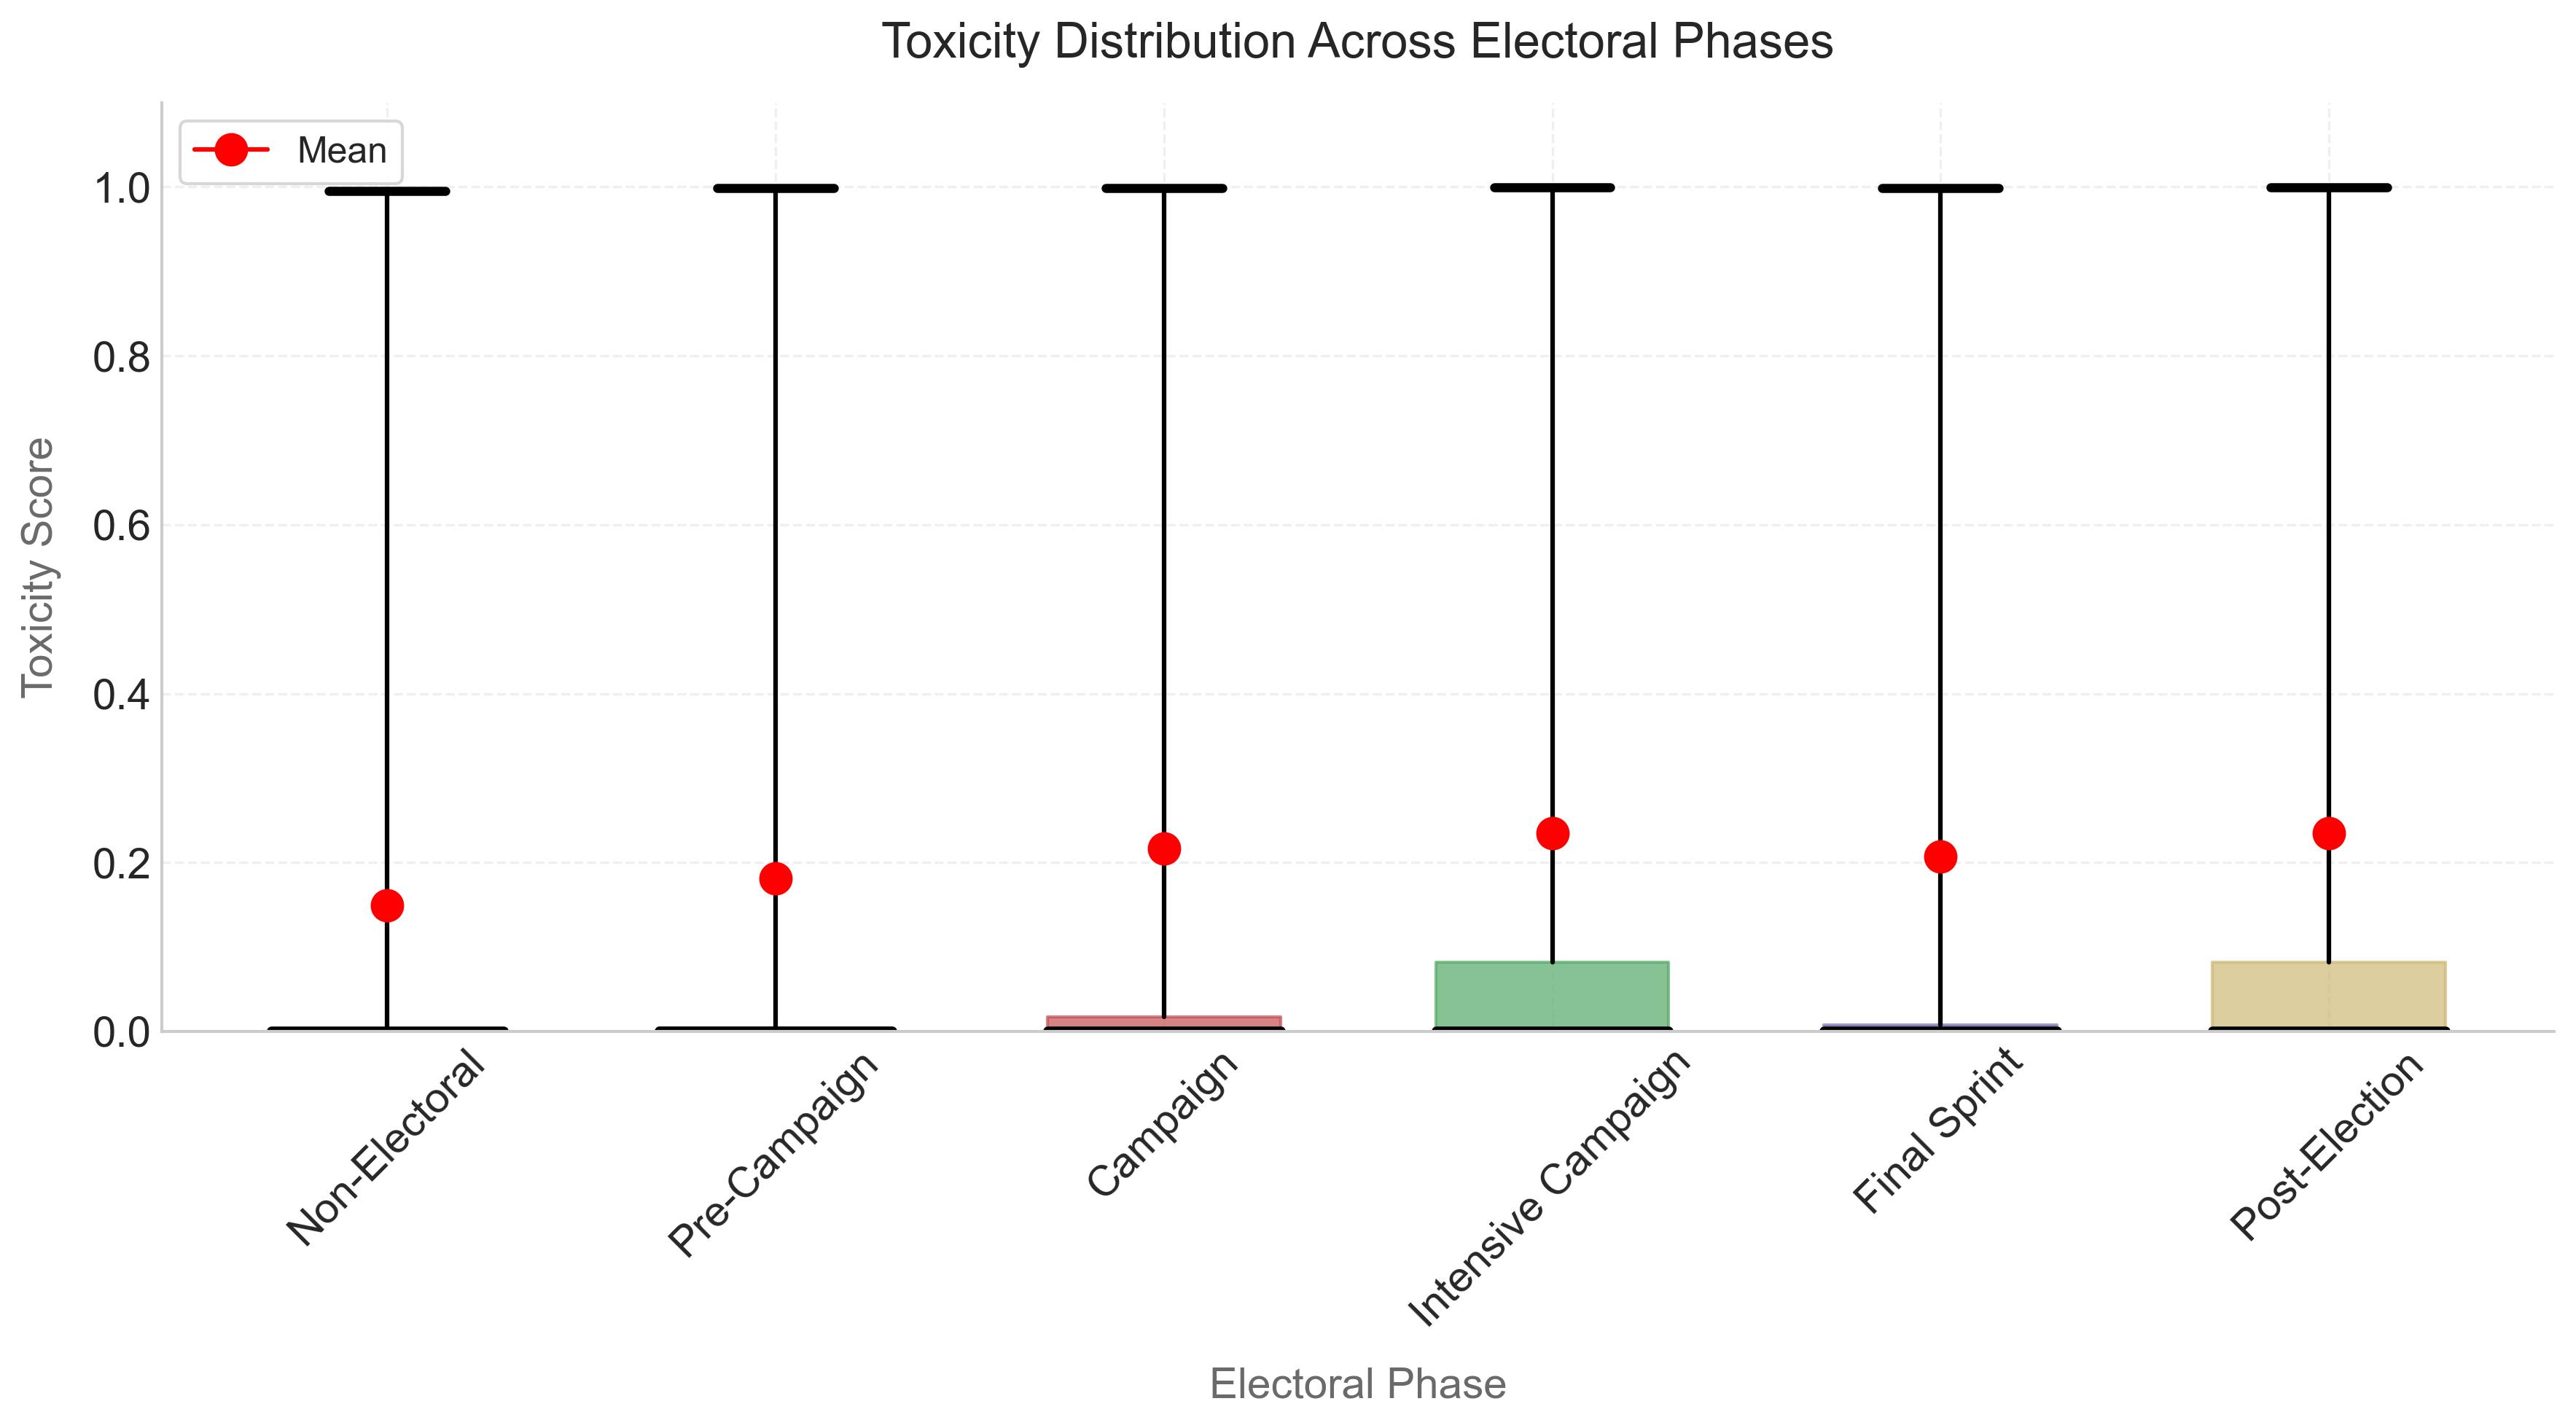

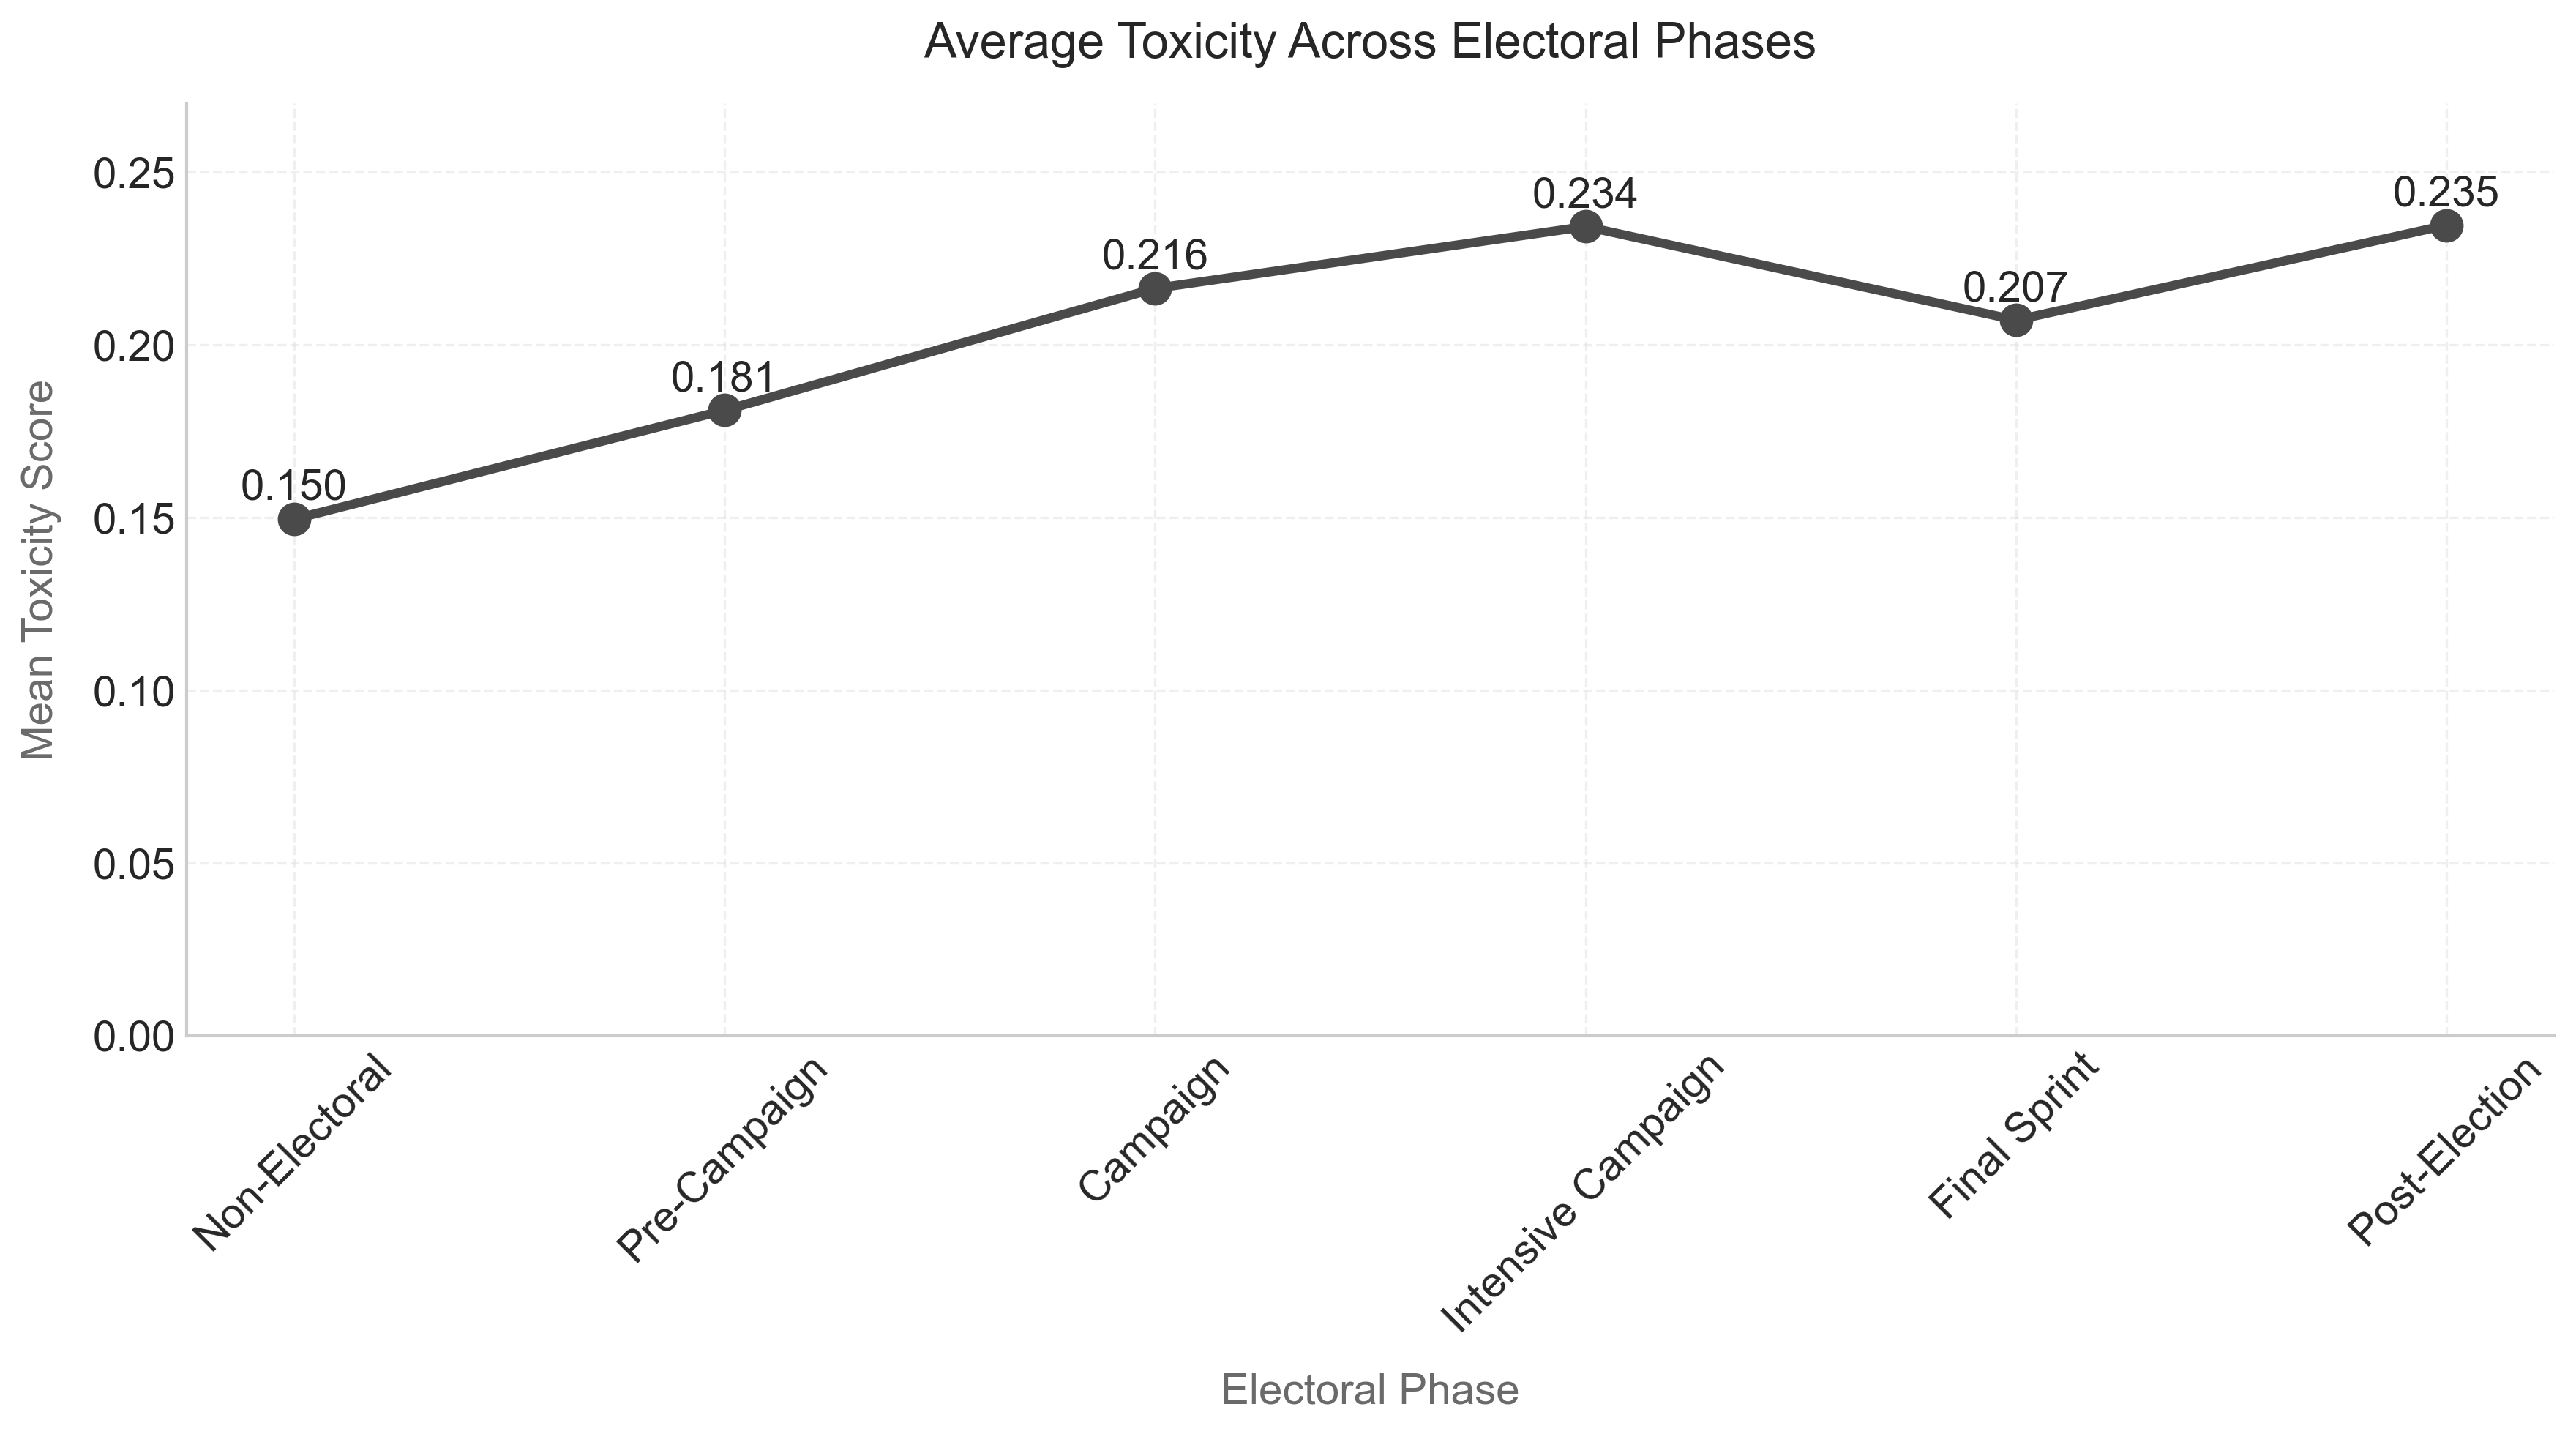

In [664]:
# Plot custom boxplot using the percentile data - refactored with format_plot
fig, ax = plt.subplots(figsize=PLOT_FIGURE_SIZE)

# Define the order
order = ['Non-Electoral', 'Pre-Campaign', 'Campaign',
         'Intensive Campaign', 'Final Sprint', 'Post-Election']

# Create positions for boxes
positions = np.arange(len(order))
box_width = 0.6

# Draw the custom boxplot
for i, phase in enumerate(order):
    if phase in boxplot_data['electoral_phase'].values:
        phase_row = boxplot_data[boxplot_data['electoral_phase'] == phase].iloc[0]

        # Extract boxplot metrics
        q1 = phase_row['q1']
        median = phase_row['median']
        q3 = phase_row['q3']
        whisker_low = phase_row['whisker_low']
        whisker_high = phase_row['whisker_high']

        # Draw box
        ax.fill_between([positions[i] - box_width/2, positions[i] + box_width/2],
                        [q1, q1], [q3, q3], color=colors[i % len(colors)], alpha=0.7)

        # Draw median line
        ax.plot([positions[i] - box_width/2, positions[i] + box_width/2],
                [median, median], color='black', linewidth=LINE_WIDTH)

        # Draw whiskers
        ax.plot([positions[i], positions[i]], [q1, whisker_low], color='black', linestyle='-')
        ax.plot([positions[i], positions[i]], [q3, whisker_high], color='black', linestyle='-')

        # Draw whisker caps
        ax.plot([positions[i] - box_width/4, positions[i] + box_width/4],
                [whisker_low, whisker_low], color='black', linewidth=LINE_WIDTH)
        ax.plot([positions[i] - box_width/4, positions[i] + box_width/4],
                [whisker_high, whisker_high], color='black', linewidth=LINE_WIDTH)

        # Add mean marker
        mean_val = phase_stats_df[phase_stats_df['electoral_phase'] == phase]['mean_toxicity'].values[0]
        ax.plot(positions[i], mean_val, marker='o', markersize=MARKER_SIZE, color='red',
                label='Mean' if i == 0 else "")

# Customize the plot
ax.set_xticks(positions)
ax.set_xticklabels(order, rotation=45)

# Apply standard formatting
format_plot(
    ax,
    title='Toxicity Distribution Across Electoral Phases',
    xlabel='Electoral Phase',
    ylabel='Toxicity Score',
    ylim_start=0,
    ylim_end=boxplot_data['whisker_high'].max() * 1.1,
    legend_loc=LEGEND_POSITION
)

plt.tight_layout()
file_name = 'toxicity_by_phase_boxplot.png'
plt.savefig(os.path.join(OUTPUT_DIR, file_name) , dpi=PLOT_DPI, bbox_inches='tight')
plt.show()
plt.close()

# Create a time series line chart of average toxicity by phase - refactored with format_plot
fig, ax = plt.subplots(figsize=PLOT_FIGURE_SIZE)
ax.plot(range(len(order)), phase_stats_df['mean_toxicity'],
         marker='o', markersize=MARKER_SIZE, linestyle='-', linewidth=LINE_WIDTH, color=colors[0])




for i, row in phase_stats_df.iterrows():
    ax.text(
        i,
        row['mean_toxicity'] + 0.003,
        f"{row['mean_toxicity']:.3f}",
        ha='center',
        va='bottom',
        fontsize=BASE_FONT_SIZE,
        
        # xytext=(0, 10),
        # textcoords='offset points',
    )

ax.set_xticks(range(len(order)))
ax.set_xticklabels(order, rotation=45)

# Apply standard formatting
format_plot(
    ax,
    title='Average Toxicity Across Electoral Phases',
    xlabel='Electoral Phase',
    ylabel='Mean Toxicity Score',
    ylim_start=0,
    ylim_end=phase_stats_df['mean_toxicity'].max() * 1.15
)

plt.tight_layout()
file_name = 'toxicity_by_phase_trend.png'
plt.savefig(os.path.join(OUTPUT_DIR, file_name) , dpi=PLOT_DPI, bbox_inches='tight')
plt.show()
plt.close()

### Monthly Toxicity Trends with Electoral Phase Highlights

Let's analyze the toxicity trends by month, highlighting the different electoral phases.

Query executed successfully. Retrieved 24 rows.
Columns: ['month', 'mean_toxicity', 'tweet_count']


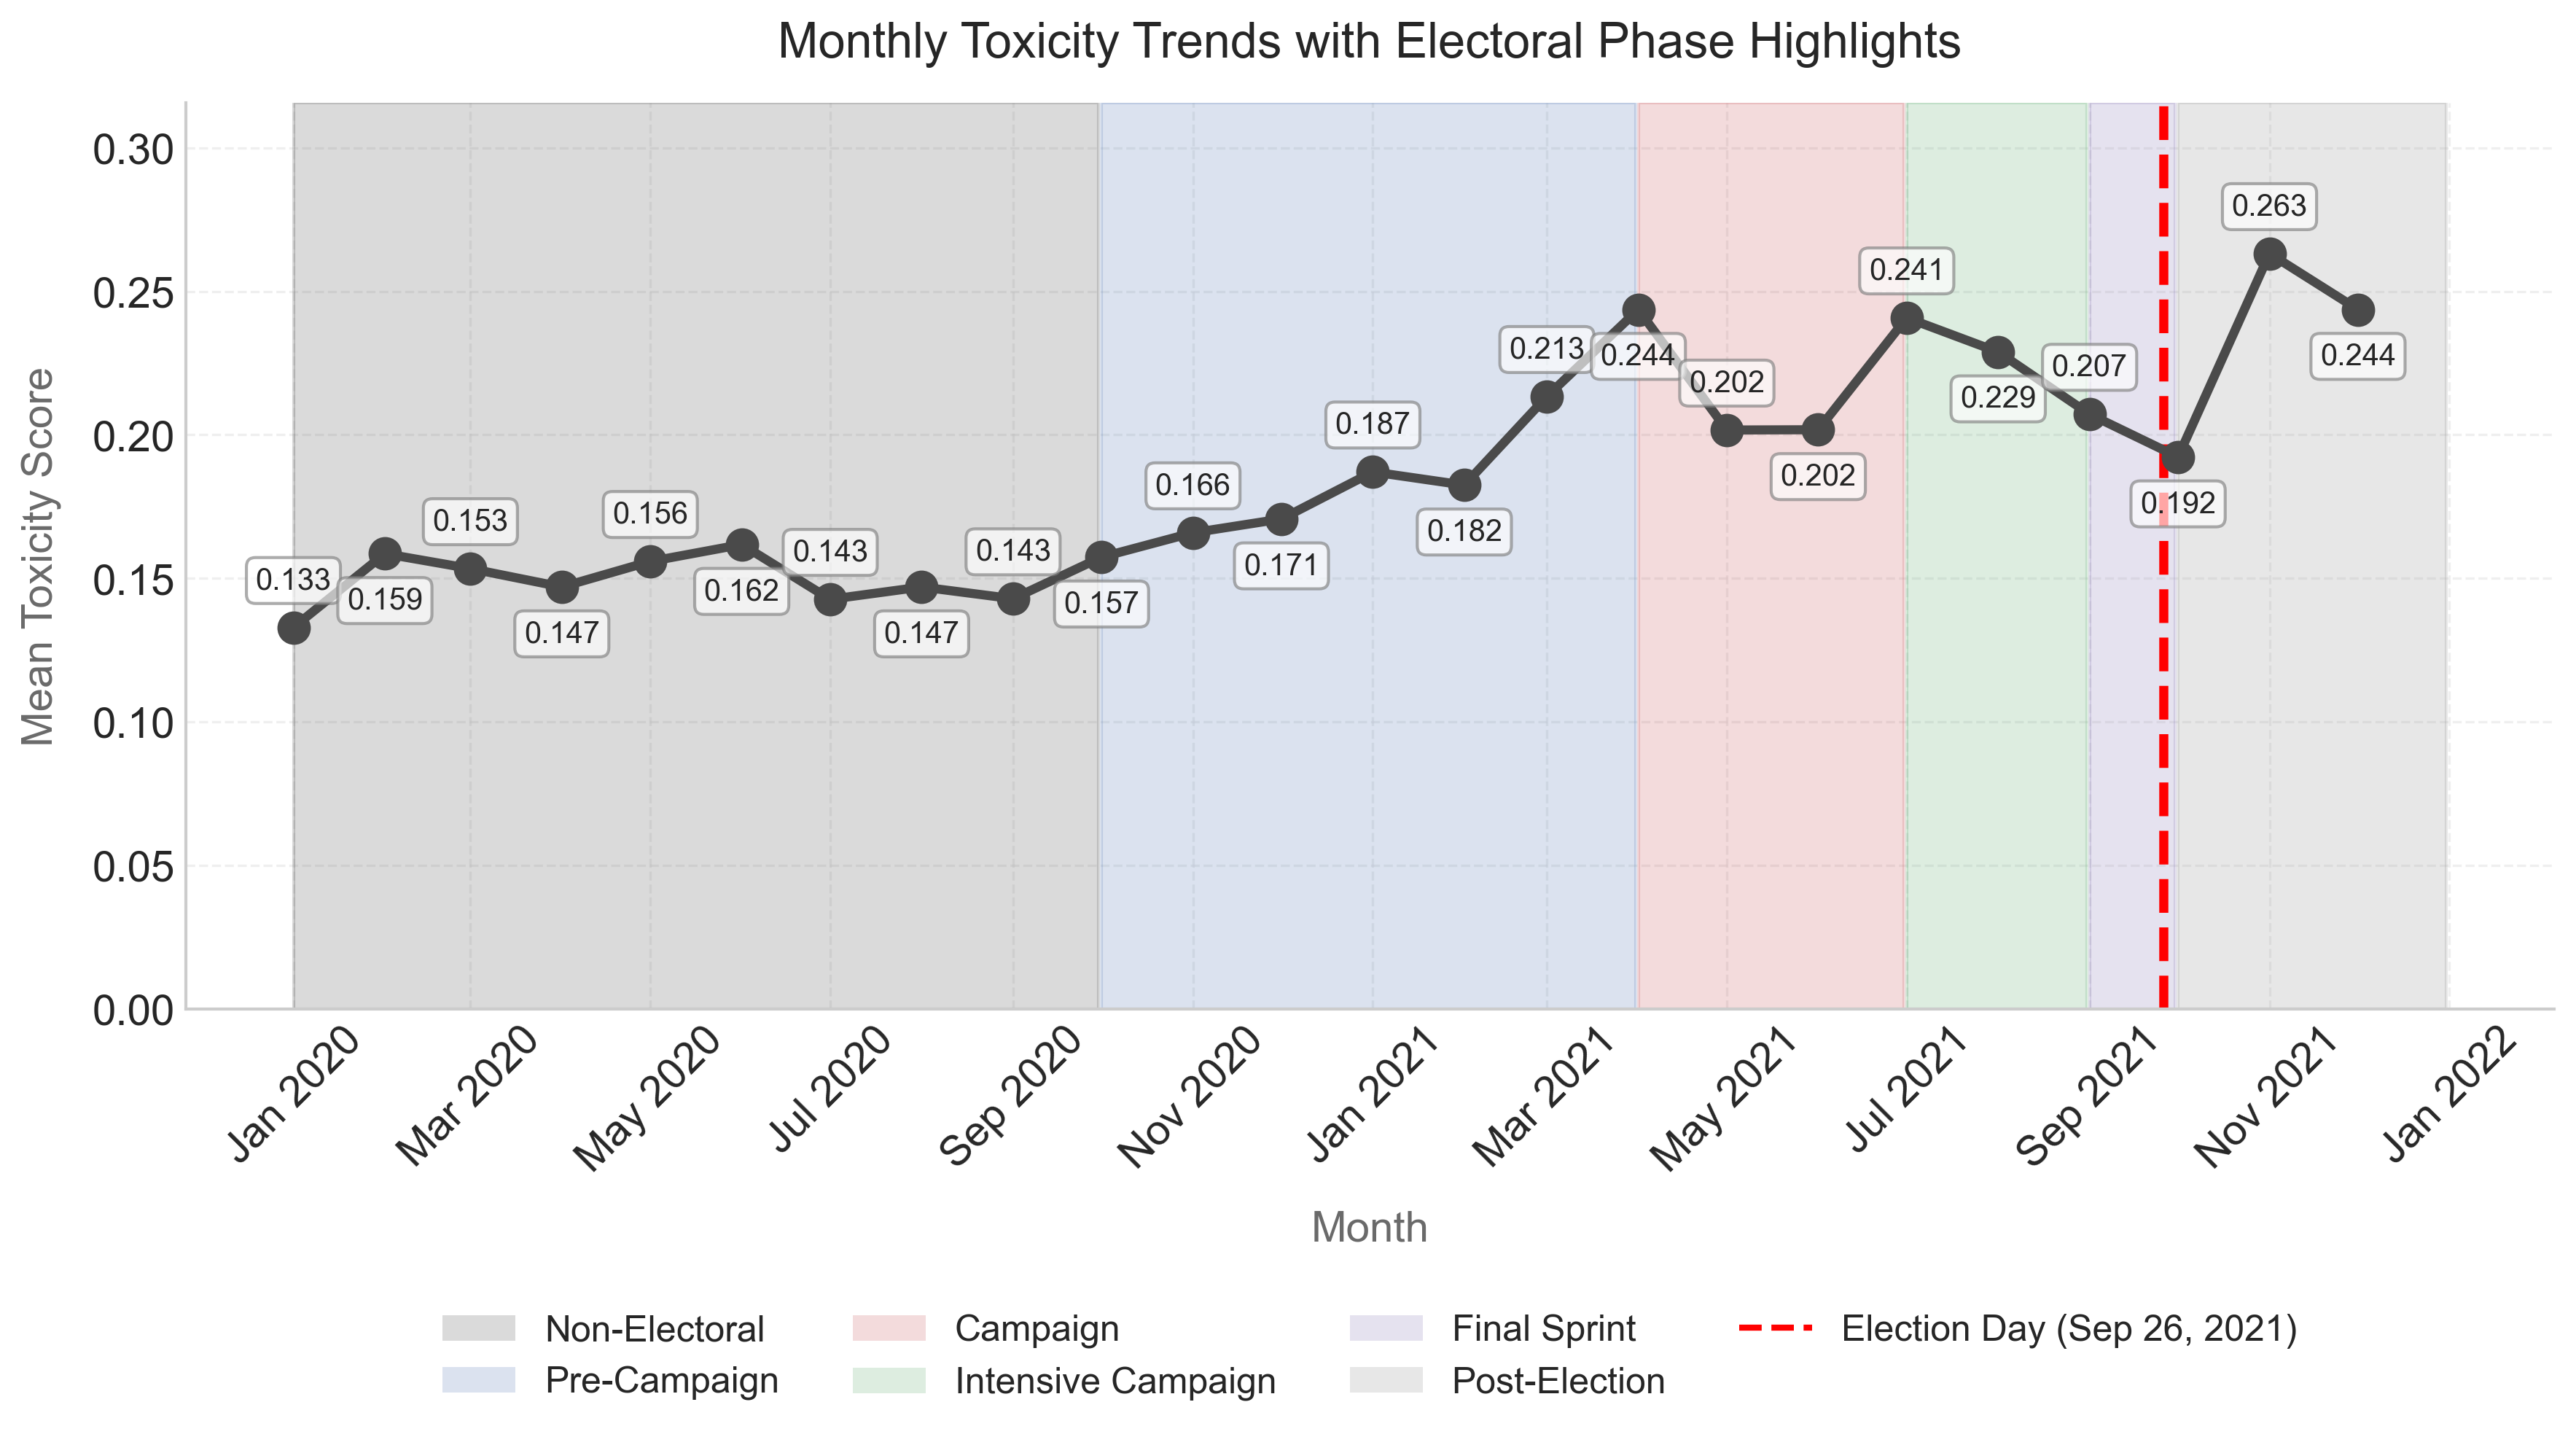

In [665]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from matplotlib.patches import Patch

# Query for monthly average toxicity
monthly_toxicity_query = """
SELECT 
    DATE_TRUNC(created_at, MONTH) AS month,
    ROUND(AVG(toxicity_score), 4) AS mean_toxicity,
    COUNT(*) AS tweet_count
FROM `grounded-nebula-408412.twitter_analysis_20_curated.tweets_relevant_with_predictions`
WHERE
    toxicity_score IS NOT NULL 
    AND toxicity_score BETWEEN 0 AND 1
    AND created_at BETWEEN '2020-01-01' AND '2021-12-31'
GROUP BY month
ORDER BY month
"""

monthly_toxicity_df = run_query(monthly_toxicity_query)
monthly_toxicity_df['month'] = pd.to_datetime(monthly_toxicity_df['month'])

# Define electoral phases with their date ranges
electoral_phases = [
    {'name': 'Non-Electoral', 'start': '2020-01-01', 'end': '2020-09-30', 'color': colors[0]},
    {'name': 'Pre-Campaign', 'start': '2020-10-01', 'end': '2021-03-31', 'color': colors[1]},
    {'name': 'Campaign', 'start': '2021-04-01', 'end': '2021-06-30', 'color': colors[2]},
    {'name': 'Intensive Campaign', 'start': '2021-07-01', 'end': '2021-08-31', 'color': colors[3]},
    {'name': 'Final Sprint', 'start': '2021-09-01', 'end': '2021-09-30', 'color': colors[4]},
    {'name': 'Post-Election', 'start': '2021-10-01', 'end': '2021-12-31', 'color': '#8B8B8B'}
]

# Create the monthly trend chart with electoral phase highlighting - refactored with format_plot
fig, ax = plt.subplots(figsize=PLOT_FIGURE_SIZE)

# Plot the line (with zorder=10)
ax.plot(monthly_toxicity_df['month'], monthly_toxicity_df['mean_toxicity'],
        marker='o', markersize=MARKER_SIZE, linewidth=LINE_WIDTH, color='#4A4A4A', zorder=10)

# Add value labels for each month
for i, row in monthly_toxicity_df.iterrows():
    position = 'top' if i % 2 == 0 else 'bottom'
    offset_points = 20
    offset = offset_points if position == 'top' else -offset_points

    ax.annotate(f"{row['mean_toxicity']:.3f}",
                xy=(row['month'], row['mean_toxicity']),
                xytext=(0, offset),
                textcoords='offset points',
                ha='center',
                va=position,
                fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3",
                          fc="white",
                          ec="gray",
                          alpha=0.65),
                zorder=120)

# Highlight electoral phases with colored backgrounds
handles = []
for phase in electoral_phases:
    start_date = pd.to_datetime(phase['start'])
    end_date = pd.to_datetime(phase['end'])

    # Add colored background for each phase (zorder=1, behind everything)
    ax.axvspan(start_date, end_date, alpha=0.2, color=phase['color'], zorder=1)

    # Create a patch for the legend
    handles.append(Patch(facecolor=phase['color'], alpha=0.2, label=phase['name']))

# Add election line
add_election_line(ax, label=True)

# Format x-axis to show months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Apply standard formatting
format_plot(
    ax,
    title='Monthly Toxicity Trends with Electoral Phase Highlights',
    xlabel='Month',
    ylabel='Mean Toxicity Score',
    ylim_start=0,
    ylim_end=monthly_toxicity_df['mean_toxicity'].max() * 1.2
)

# Add legend
all_handles = handles + [plt.Line2D([0], [0], color='red', lw=2, linestyle='--')]
all_labels = [h.get_label() for h in handles] + [ELECTION_DATE_LABEL]
padding = 0.3
ax.legend(handles=all_handles, labels=all_labels,
         loc='upper center', bbox_to_anchor=(0.5, -padding),
         fancybox=True, shadow=True, ncol=4)

plt.tight_layout()
plt.subplots_adjust(bottom=padding)
file_name = 'monthly_toxicity_with_phases.png'
plt.savefig(os.path.join(OUTPUT_DIR, file_name) , dpi=PLOT_DPI, bbox_inches='tight')
plt.show()
plt.close()


### Comparing Toxicity Across Different Discourse Topics

Now, let's compare toxicity levels between general political discourse, climate-related discussions, and migration-related discussions.

Query executed successfully. Retrieved 72 rows.
Columns: ['month', 'mean_toxicity', 'tweet_count', 'topic']


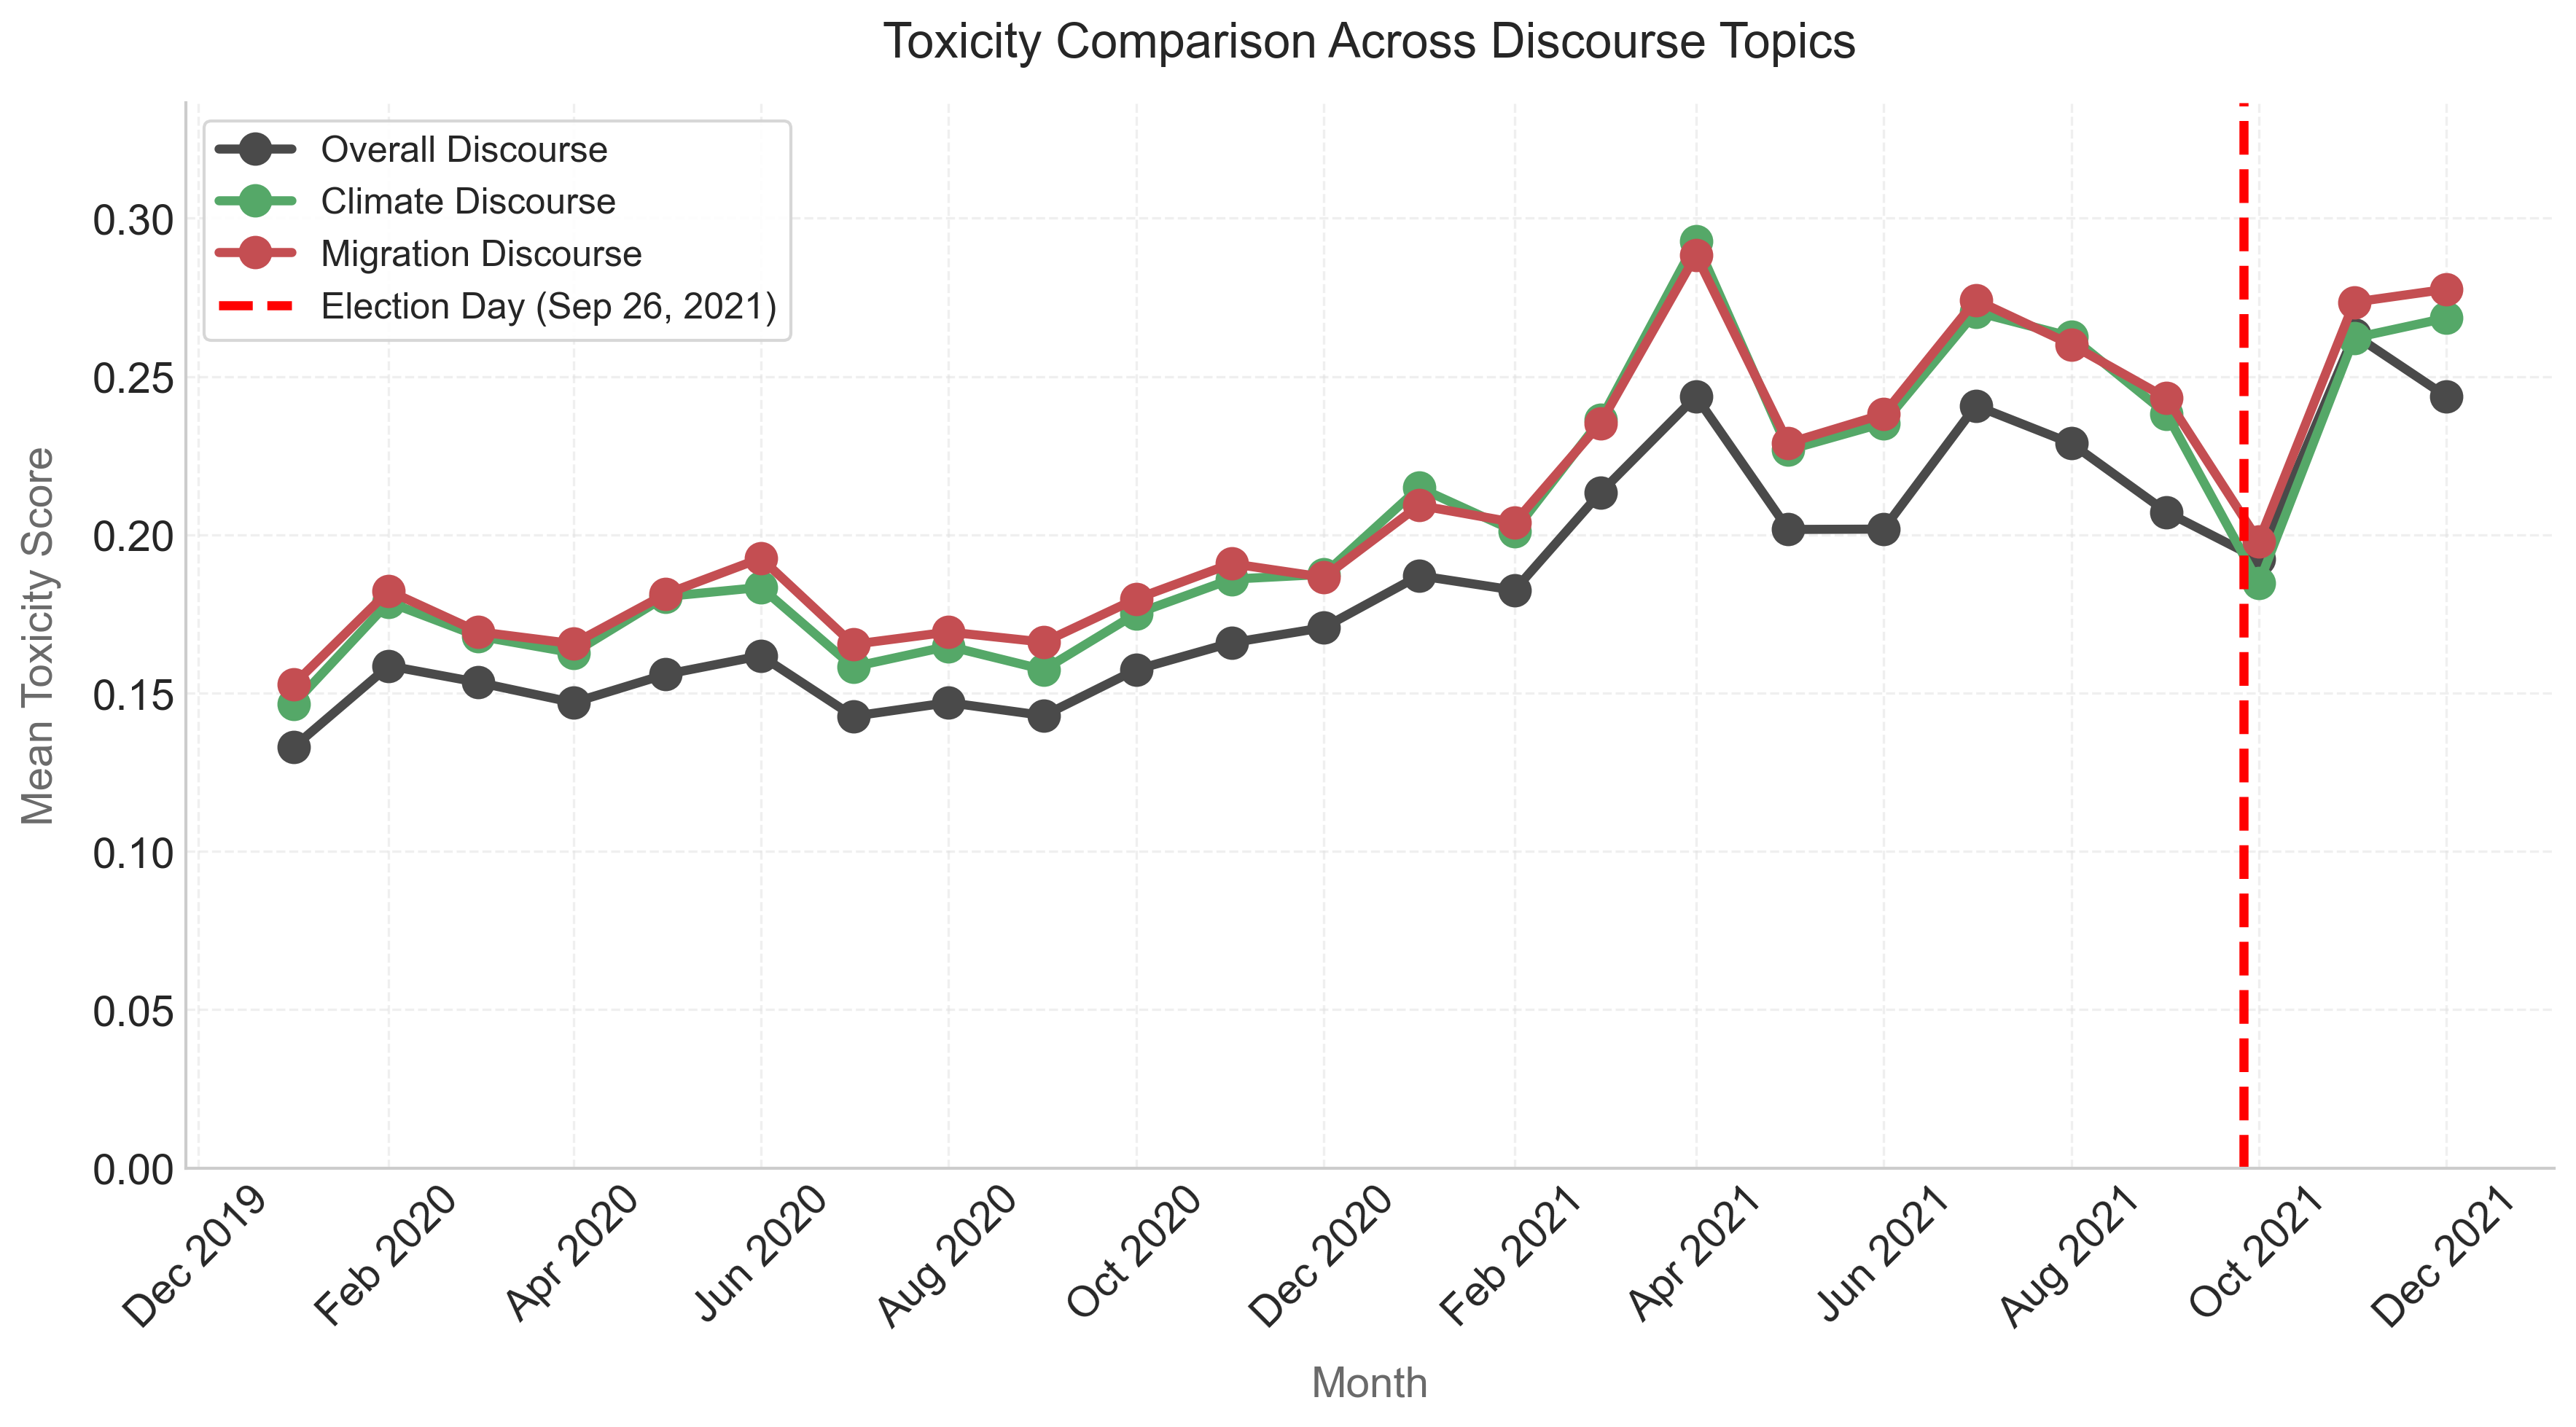

In [666]:
# Set custom order for topics
topic_order = ['Overall', 'Climate', 'Migration']
topic_colors = [colors[0], colors[3], colors[2]]

# Query for topic comparison
topic_comparison_query = """
WITH overall AS (
    SELECT 
        DATE_TRUNC(created_at, MONTH) AS month,
        ROUND(AVG(toxicity_score), 4) AS mean_toxicity,
        COUNT(*) AS tweet_count,
        'Overall' AS topic
    FROM `grounded-nebula-408412.twitter_analysis_20_curated.tweets_relevant_with_predictions`
    WHERE
        toxicity_score IS NOT NULL 
        AND toxicity_score BETWEEN 0 AND 1
        AND created_at BETWEEN '2020-01-01' AND '2021-12-31'
    GROUP BY month
), 
climate AS (
    SELECT 
        DATE_TRUNC(created_at, MONTH) AS month,
        ROUND(AVG(toxicity_score), 4) AS mean_toxicity,
        COUNT(*) AS tweet_count,
        'Climate' AS topic
    FROM `grounded-nebula-408412.twitter_analysis_20_curated.tweets_relevant_climate`
    WHERE
        toxicity_score IS NOT NULL 
        AND toxicity_score BETWEEN 0 AND 1
        AND created_at BETWEEN '2020-01-01' AND '2021-12-31'
    GROUP BY month
),
migration AS (
    SELECT 
        DATE_TRUNC(created_at, MONTH) AS month,
        ROUND(AVG(toxicity_score), 4) AS mean_toxicity,
        COUNT(*) AS tweet_count,
        'Migration' AS topic
    FROM `grounded-nebula-408412.twitter_analysis_20_curated.tweets_relevant_migration`
    WHERE
        toxicity_score IS NOT NULL 
        AND toxicity_score BETWEEN 0 AND 1
        AND created_at BETWEEN '2020-01-01' AND '2021-12-31'
    GROUP BY month
)
SELECT * FROM overall
UNION ALL
SELECT * FROM climate
UNION ALL
SELECT * FROM migration
ORDER BY topic, month
"""

topic_comparison_df = run_query(topic_comparison_query)
topic_comparison_df['month'] = pd.to_datetime(topic_comparison_df['month'])

# Create a pivot table for easier plotting
pivot_df = topic_comparison_df.pivot(index='month', columns='topic', values='mean_toxicity')

# Create plot comparing topics - refactored with format_plot
fig, ax = plt.subplots(figsize=PLOT_FIGURE_SIZE)

# Plot each topic line
for i, topic in enumerate(['Overall', 'Climate', 'Migration']):
    if topic in pivot_df.columns:
        ax.plot(pivot_df.index, pivot_df[topic],
                marker='o', markersize=MARKER_SIZE, linewidth=LINE_WIDTH,
                color=topic_colors[i], label=f"{topic} Discourse")

# Add election line
add_election_line(ax)

# Format x-axis to show months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Apply standard formatting
format_plot(
    ax,
    title='Toxicity Comparison Across Discourse Topics',
    xlabel='Month',
    ylabel='Mean Toxicity Score',
    ylim_start=0,
    ylim_end=pivot_df.values.max() * 1.15,
    legend_loc=LEGEND_POSITION
)

plt.tight_layout()
file_name = 'toxicity_comparison_by_topic.png'
plt.savefig(os.path.join(OUTPUT_DIR, file_name) , dpi=PLOT_DPI, bbox_inches='tight')
plt.show()
plt.close()

Query executed successfully. Retrieved 3 rows.
Columns: ['mean_toxicity', 'tweet_count', 'topic']


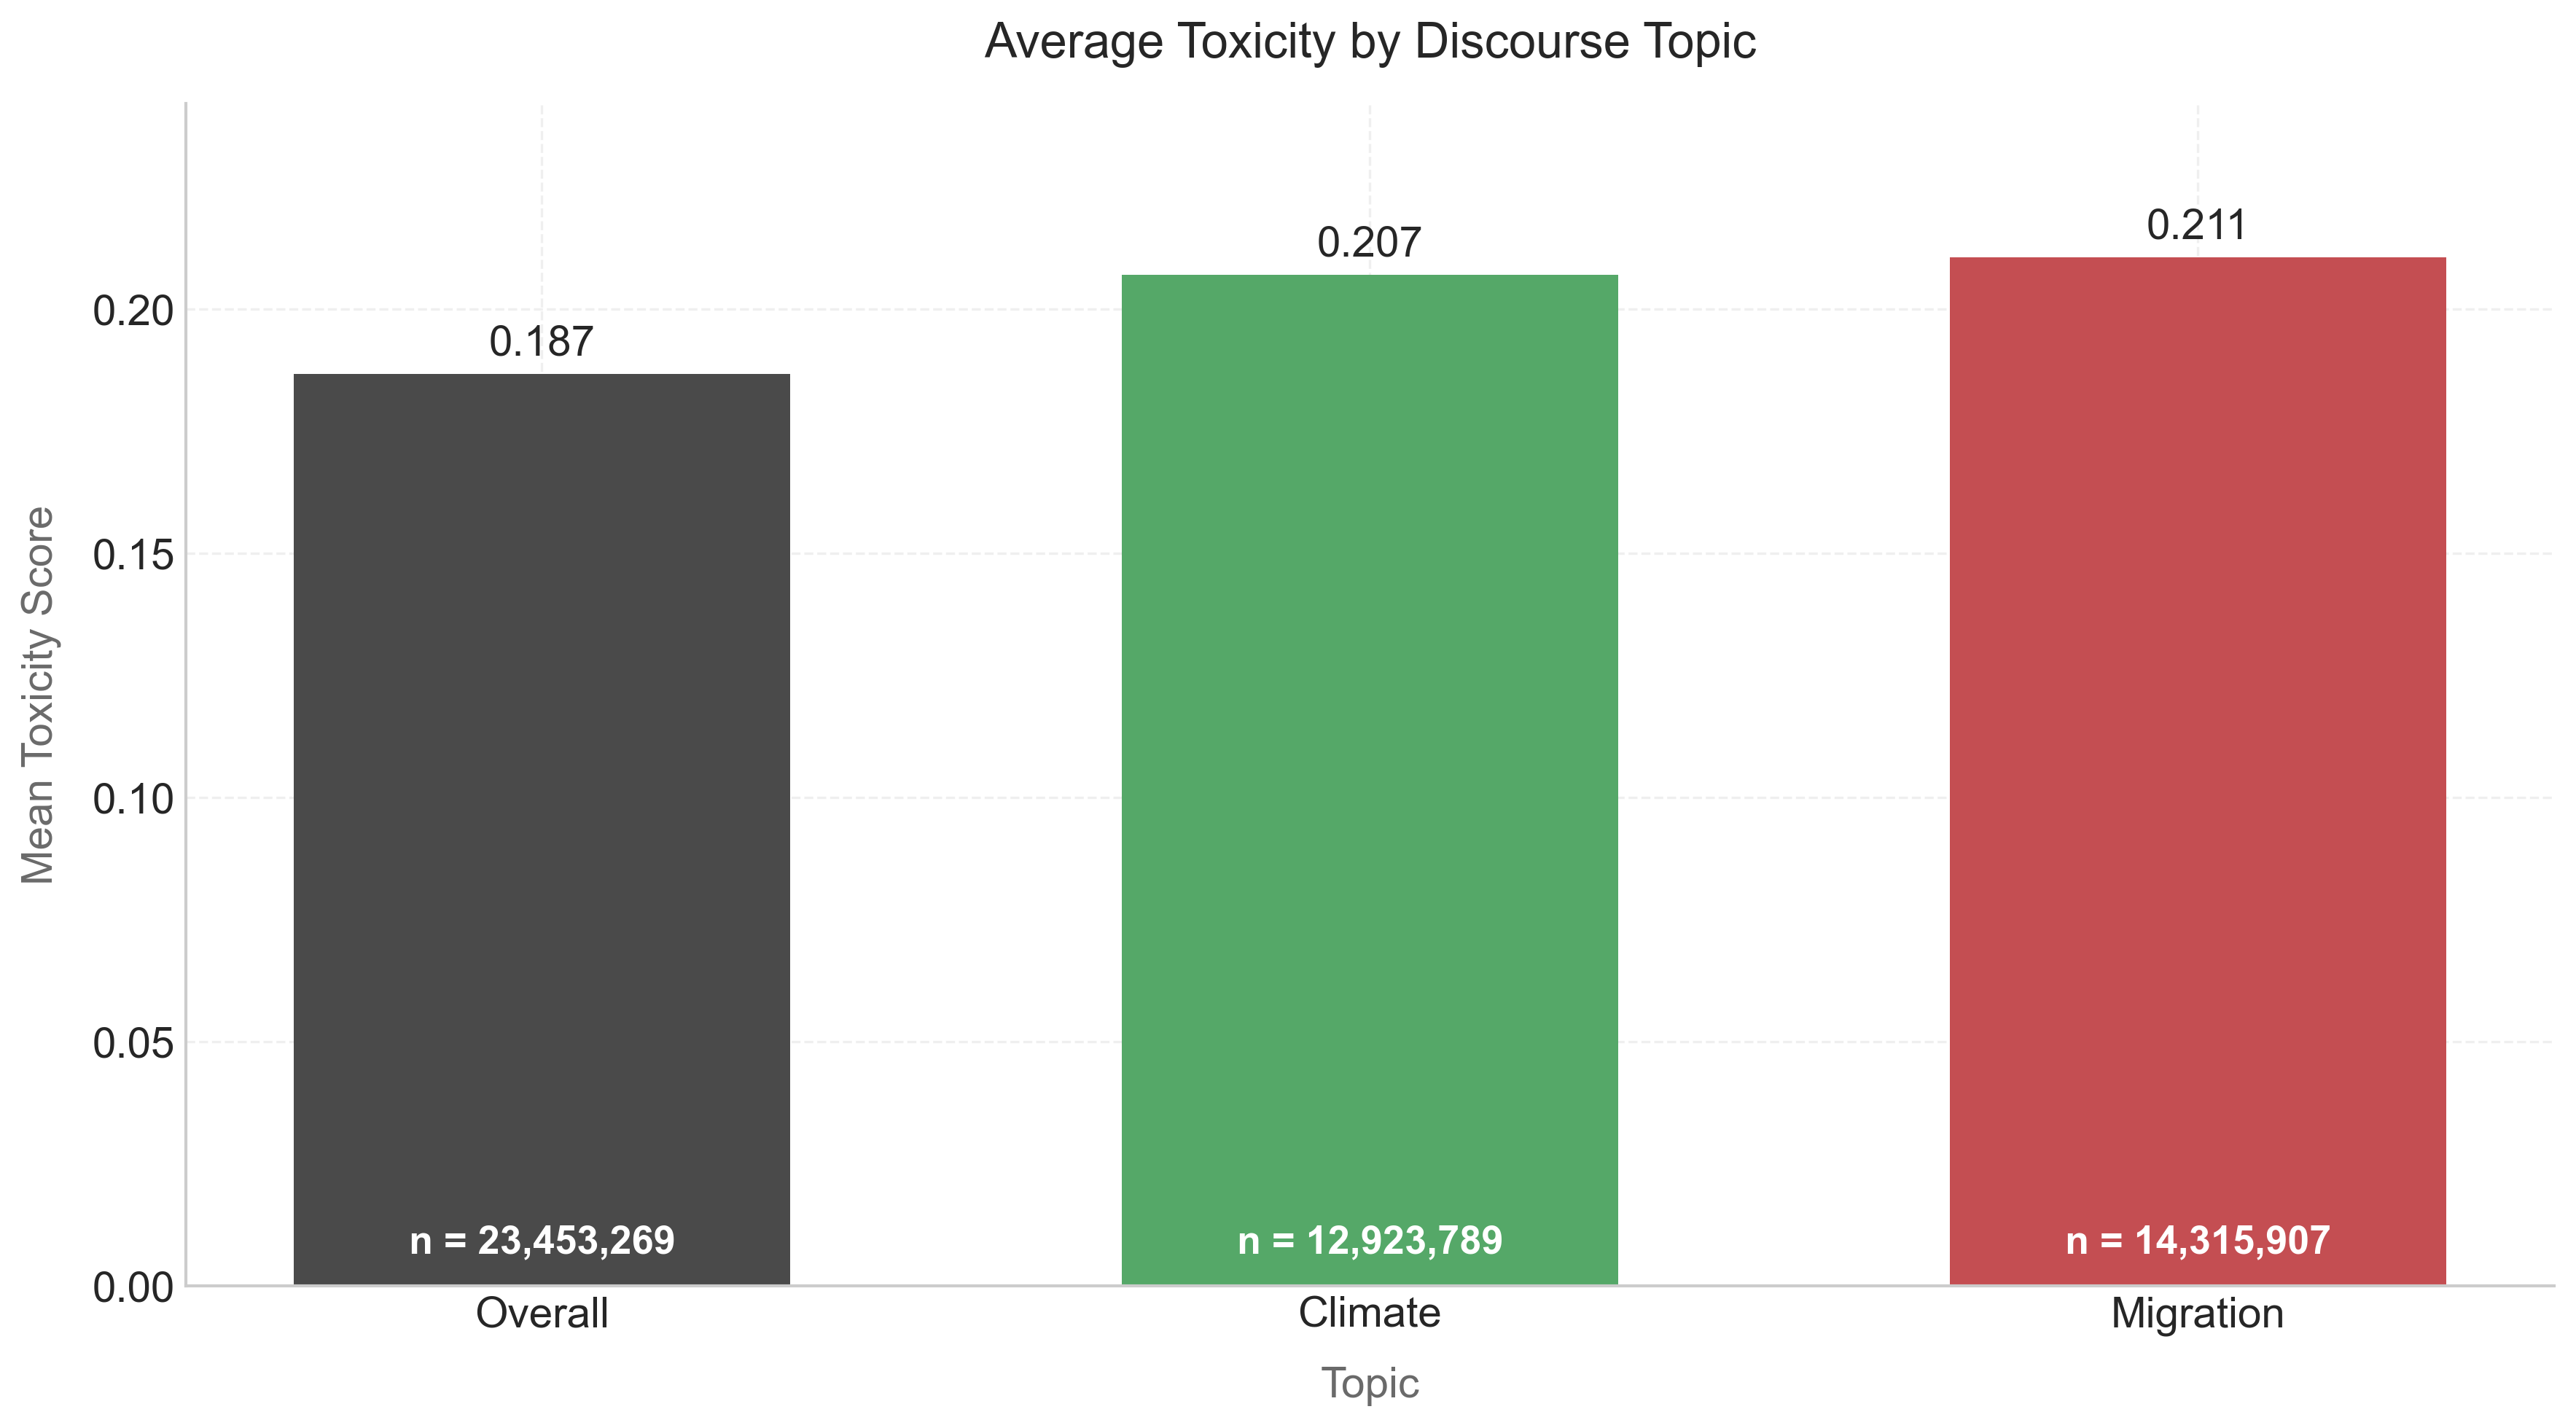

In [667]:
# Create a bar chart comparing average toxicity by topic across all periods
topic_summary_query = """
WITH overall AS (
    SELECT 
        ROUND(AVG(toxicity_score), 4) AS mean_toxicity,
        COUNT(*) AS tweet_count,
        'Overall' AS topic
    FROM `grounded-nebula-408412.twitter_analysis_20_curated.tweets_relevant_with_predictions`
    WHERE
        toxicity_score IS NOT NULL 
        AND toxicity_score BETWEEN 0 AND 1
        AND created_at BETWEEN '2020-01-01' AND '2021-12-31'
), 
climate AS (
    SELECT 
        ROUND(AVG(toxicity_score), 4) AS mean_toxicity,
        COUNT(*) AS tweet_count,
        'Climate' AS topic
    FROM `grounded-nebula-408412.twitter_analysis_20_curated.tweets_relevant_climate`
    WHERE
        toxicity_score IS NOT NULL 
        AND toxicity_score BETWEEN 0 AND 1
        AND created_at BETWEEN '2020-01-01' AND '2021-12-31'
),
migration AS (
    SELECT 
        ROUND(AVG(toxicity_score), 4) AS mean_toxicity,
        COUNT(*) AS tweet_count,
        'Migration' AS topic
    FROM `grounded-nebula-408412.twitter_analysis_20_curated.tweets_relevant_migration`
    WHERE
        toxicity_score IS NOT NULL 
        AND toxicity_score BETWEEN 0 AND 1
        AND created_at BETWEEN '2020-01-01' AND '2021-12-31'
)
SELECT * FROM overall
UNION ALL
SELECT * FROM climate
UNION ALL
SELECT * FROM migration
ORDER BY topic
"""

topic_summary_df = run_query(topic_summary_query)

# Create bar chart - refactored with format_plot
fig, ax = plt.subplots(figsize=PLOT_FIGURE_SIZE)

# Filter and order the dataframe
ordered_df = pd.DataFrame([
    topic_summary_df[topic_summary_df['topic'] == topic].iloc[0]
    for topic in topic_order if topic in topic_summary_df['topic'].values
])

# Plot bars
bars = ax.bar(
    ordered_df['topic'],
    ordered_df['mean_toxicity'],
    color=topic_colors[:len(ordered_df)],
    width=0.6
)

# Add toxicity value on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2.,
        height + 0.002,
        f'{height:.3f}',
        ha='center',
        va='bottom',
        fontsize=DEFAULT_FONT_SIZE
    )

# Add tweet count at the bottom of the bars in white
for i, (bar, (_, row)) in enumerate(zip(bars, ordered_df.iterrows())):
    # Position the text at the bottom of the bar
    ax.text(
        bar.get_x() + bar.get_width()/2.,
        0.005,  # Slightly above the bottom
        f'n = {row["tweet_count"]:,}',
        ha='center',
        va='bottom',
        color='white',
        fontsize=DEFAULT_FONT_SIZE-1,
        fontweight='bold'
    )

# Apply standard formatting
format_plot(
    ax,
    title='Average Toxicity by Discourse Topic',
    xlabel='Topic',
    ylabel='Mean Toxicity Score',
    ylim_start=0,
    ylim_end=ordered_df['mean_toxicity'].max() * 1.15
)

plt.tight_layout()
file_name = 'toxicity_by_topic_summary.png'
plt.savefig(os.path.join(OUTPUT_DIR, file_name) , dpi=PLOT_DPI, bbox_inches='tight')
plt.show()
plt.close()



In [668]:

get_table_schema("network_metrics_all", "twitter_analysis_00_source_python")



Column Name Data Type      Mode
0                  row_id    STRING  NULLABLE
1             month_start      DATE  NULLABLE
2              table_name    STRING  NULLABLE
3                   nodes   INTEGER  NULLABLE
4                   edges   INTEGER  NULLABLE
5                 density     FLOAT  NULLABLE
6    connected_components   INTEGER  NULLABLE
7            transitivity     FLOAT  NULLABLE
8              modularity     FLOAT  NULLABLE
9      modularity_classes   INTEGER  NULLABLE
10          assortativity     FLOAT  NULLABLE
11   network_avg_toxicity     FLOAT  NULLABLE
12   median_node_toxicity     FLOAT  NULLABLE
13        max_core_number   INTEGER  NULLABLE
14        avg_core_number     FLOAT  NULLABLE
15  rich_club_coefficient     FLOAT  NULLABLE
16     average_clustering     FLOAT  NULLABLE